

<hr style="margin-bottom: 40px;">

# Principal - Backtesting

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## (A) (B) Simplified

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

df = pd.read_excel("Principal.xlsx", parse_dates=True, index_col="date")
df.apply(pd.to_numeric, errors='ignore')
df = df.rename(columns=lambda x: x.strip())
df = df.dropna(axis="index",how="all") #drop NaN values. The earliest data starts from 2001-11-20.
df = df.drop(["PRSSCOA HK Equity"],axis=1)

In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return

In [3]:
describe = df.describe()
describe = pd.DataFrame(describe)
describe = describe.T
describe

,count,mean,std,min,25%,50%,75%,max
PRIAGSD HK Equity,1563.0,20.006846,2.112108,15.6100,18.160000,19.81000,21.940000,24.7500
PRIGLGC HK Equity,4801.0,16.644212,5.180473,7.4400,11.740000,17.18000,20.650000,26.5500
PRIHDSC HK Equity,4763.0,10.756074,0.300939,10.0390,10.383300,10.89080,10.937000,11.3056
PRILTAC HK Equity,4766.0,14.554230,3.491566,8.3228,11.042025,14.89255,17.333125,20.9627
PRILTGC HK Equity,4766.0,11.467751,1.366887,8.1355,10.296325,11.81295,12.709800,13.7850
PRICAPC HK Equity,4767.0,10.959695,0.402181,10.0980,10.450350,11.19940,11.229500,11.5160
PRASBON HK Equity,1798.0,9.981389,0.312778,9.4659,9.756450,9.90505,10.125125,10.9521
PRISTYC HK Equity,4766.0,14.457342,2.802819,9.4267,11.751625,14.97250,16.683100,19.5264


In [4]:
# get a list of all the column names 
indexNamesArr = describe.index.values
# convert ndarray to list
listOfRowIndexLabels = list(indexNamesArr)

coord = [(0.038802, 1.598254),( 0.023617, 0.745137),( 0.025753, 0.802417),( 0.045350, 2.066649),( 0.106415, 0.574546),( 0.053244, 0.432762),( 0.039204, 1.853161),( 0.059571, 0.444722),( 0.024976, 2.706996),( 0.012862, 0.312357),( 0.039587, 2.285998),( 0.001826, 0.044556),( 0.027979, 1.050875),( 0.032775, 1.438767),( 0.040590, 2.009521),( 0.042759, 2.400255)]
labels = listOfRowIndexLabels

def plot_with_labels(coord, labels):
    assert len(coord) == len(labels), 'coord len is not equal to labels len'
    plt.figure(figsize=(10,30))
    plt.xlabel('Mean historic return')
    plt.ylabel('volatility')
    plt.title("Performance of Principal Funds")
    plt
    for i, label in enumerate(labels): #get (0, label)
        x, y = coord[i] #2 dim
        plt.scatter(x, y,)
                #
        plt.annotate(label,
                xy=(x, y), #show point 
                xytext=(5, 2), #show annotate
                textcoords='offset points',
                ha='right',
                va='bottom')
    plt.show()
    
plot_with_labels(coord, labels)

AssertionError: coord len is not equal to labels len

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## (C) - Backtesting and Optimization

### Split training set and test set

1. Split data in train and test set given a Date (i.e. test set is what happens after 31 July 2020 not included).

2. Further split train set into train set and validation set (i.e. what happens before 31 July 2020 included) in 6 consecutive time folds.

Then, in order not lo lose the time information, perform the following steps:
 
one = Train on fold 10,11,12,13 (2010-08-01 to 2014-07-31) –>  Test on fold 14 (2014-08-01 to 2015-07-31)

two = Train on fold 11,12,13,14 –>  Test on fold 15 

three = Train on fold 12,13,14,15 –>  Test on fold 16

four = Train on fold 13,14,15,16 –>  Test on fold 17

five = Train on fold 14,15,16,17 –>  Test on fold 18

six = Train on fold 15,16,17,18 –>  Test on fold 19 (2019-08-01 to 2020-07-31)

Compute the average of the accuracies of the 6 test folds.

In [134]:
S = CovarianceShrinkage(df).ledoit_wolf()
mu = mean_historical_return(df)
from datetime import date
#train sets
one = df[(df.index > pd.Timestamp(date(2001,11,20))) & (df.index < pd.Timestamp(date(2004,7,31)))]
one1 = df[(df.index > pd.Timestamp(date(2002,2,1))) & (df.index < pd.Timestamp(date(2005,1,31)))]
two = df[(df.index > pd.Timestamp(date(2002,8,1))) & (df.index < pd.Timestamp(date(2005,7,31)))]
two1 = df[(df.index > pd.Timestamp(date(2003,2,1))) & (df.index < pd.Timestamp(date(2006,1,31)))]
three = df[(df.index > pd.Timestamp(date(2003,8,1))) & (df.index < pd.Timestamp(date(2006,7,31)))]
three1 = df[(df.index > pd.Timestamp(date(2004,2,1))) & (df.index < pd.Timestamp(date(2007,1,31)))]
four = df[(df.index > pd.Timestamp(date(2004,8,1))) & (df.index < pd.Timestamp(date(2007,7,31)))]
four1 = df[(df.index > pd.Timestamp(date(2005,2,1))) & (df.index < pd.Timestamp(date(2008,1,31)))]
five = df[(df.index > pd.Timestamp(date(2005,8,1))) & (df.index < pd.Timestamp(date(2008,7,31)))]
five1 = df[(df.index > pd.Timestamp(date(2006,2,1))) & (df.index < pd.Timestamp(date(2009,1,31)))]
six = df[(df.index > pd.Timestamp(date(2006,8,1))) & (df.index < pd.Timestamp(date(2009,7,31)))]
six1 = df[(df.index > pd.Timestamp(date(2007,2,1))) & (df.index < pd.Timestamp(date(2010,1,31)))]
seven = df[(df.index > pd.Timestamp(date(2007,8,1))) & (df.index < pd.Timestamp(date(2010,7,31)))]
seven1 = df[(df.index > pd.Timestamp(date(2008,2,1))) & (df.index < pd.Timestamp(date(2011,1,31)))]
eight = df[(df.index > pd.Timestamp(date(2008,8,1))) & (df.index < pd.Timestamp(date(2011,7,31)))]
eight1 = df[(df.index > pd.Timestamp(date(2009,2,1))) & (df.index < pd.Timestamp(date(2012,1,31)))]
nine = df[(df.index > pd.Timestamp(date(2009,8,1))) & (df.index < pd.Timestamp(date(2012,7,31)))]
nine1 = df[(df.index > pd.Timestamp(date(2010,2,1))) & (df.index < pd.Timestamp(date(2013,1,31)))]
ten = df[(df.index > pd.Timestamp(date(2010,8,1))) & (df.index < pd.Timestamp(date(2013,7,31)))]
ten1 = df[(df.index > pd.Timestamp(date(2011,2,1))) & (df.index < pd.Timestamp(date(2014,1,31)))]
eleven = df[(df.index > pd.Timestamp(date(2011,8,1))) & (df.index < pd.Timestamp(date(2014,7,31)))]
eleven1 = df[(df.index > pd.Timestamp(date(2012,2,1))) & (df.index < pd.Timestamp(date(2015,1,31)))]
twelve = df[(df.index > pd.Timestamp(date(2012,8,1))) & (df.index < pd.Timestamp(date(2015,7,31)))]
twelve1 = df[(df.index > pd.Timestamp(date(2013,2,1))) & (df.index < pd.Timestamp(date(2016,1,31)))]
thirteen = df[(df.index > pd.Timestamp(date(2013,8,1))) & (df.index < pd.Timestamp(date(2016,7,31)))]
thirteen1 = df[(df.index > pd.Timestamp(date(2014,2,1))) & (df.index < pd.Timestamp(date(2017,1,31)))]
fourteen = df[(df.index > pd.Timestamp(date(2014,8,1))) & (df.index < pd.Timestamp(date(2017,7,31)))]
fourteen1 = df[(df.index > pd.Timestamp(date(2015,2,1))) & (df.index < pd.Timestamp(date(2018,1,31)))]
fifteen = df[(df.index > pd.Timestamp(date(2015,8,1))) & (df.index < pd.Timestamp(date(2018,7,31)))]
fifteen1 = df[(df.index > pd.Timestamp(date(2016,2,1))) & (df.index < pd.Timestamp(date(2019,1,31)))]
sixteen = df[(df.index > pd.Timestamp(date(2016,8,1))) & (df.index < pd.Timestamp(date(2019,7,31)))]
sixteen1 = df[(df.index > pd.Timestamp(date(2017,2,1))) & (df.index < pd.Timestamp(date(2020,1,31)))]


#validation sets
tone = df[(df.index > pd.Timestamp(date(2004,8,1))) & (df.index < pd.Timestamp(date(2005,1,31)))]
tone1 = df[(df.index > pd.Timestamp(date(2005,2,1))) & (df.index < pd.Timestamp(date(2005,7,31)))]
ttwo = df[(df.index > pd.Timestamp(date(2005,8,1))) & (df.index < pd.Timestamp(date(2006,1,31)))]
ttwo1 = df[(df.index > pd.Timestamp(date(2006,2,1))) & (df.index < pd.Timestamp(date(2006,7,31)))]
tthree = df[(df.index > pd.Timestamp(date(2006,8,1))) & (df.index < pd.Timestamp(date(2007,1,31)))]
tthree1 = df[(df.index > pd.Timestamp(date(2007,2,1))) & (df.index < pd.Timestamp(date(2007,7,31)))]
tfour = df[(df.index > pd.Timestamp(date(2007,8,1))) & (df.index < pd.Timestamp(date(2008,1,31)))]
tfour1 = df[(df.index > pd.Timestamp(date(2008,2,1))) & (df.index < pd.Timestamp(date(2008,7,31)))]
tfive = df[(df.index > pd.Timestamp(date(2008,8,1))) & (df.index < pd.Timestamp(date(2009,1,31)))]
tfive1 = df[(df.index > pd.Timestamp(date(2009,2,1))) & (df.index < pd.Timestamp(date(2009,7,31)))]
tsix = df[(df.index > pd.Timestamp(date(2009,8,1))) & (df.index < pd.Timestamp(date(2010,1,31)))]
tsix1 = df[(df.index > pd.Timestamp(date(2010,2,1))) & (df.index < pd.Timestamp(date(2010,7,31)))]
tseven = df[(df.index > pd.Timestamp(date(2010,8,1))) & (df.index < pd.Timestamp(date(2011,1,31)))]
tseven1 = df[(df.index > pd.Timestamp(date(2011,2,1))) & (df.index < pd.Timestamp(date(2011,7,31)))]
teight = df[(df.index > pd.Timestamp(date(2011,8,1))) & (df.index < pd.Timestamp(date(2012,1,31)))]
teight1 = df[(df.index > pd.Timestamp(date(2012,2,1))) & (df.index < pd.Timestamp(date(2012,7,31)))]
tnine = df[(df.index > pd.Timestamp(date(2012,8,1))) & (df.index < pd.Timestamp(date(2013,1,31)))]
tnine1 = df[(df.index > pd.Timestamp(date(2013,2,1))) & (df.index < pd.Timestamp(date(2013,7,31)))]
tten = df[(df.index > pd.Timestamp(date(2013,8,1))) & (df.index < pd.Timestamp(date(2014,1,31)))]
tten1 = df[(df.index > pd.Timestamp(date(2014,2,1))) & (df.index < pd.Timestamp(date(2014,7,31)))]
televen = df[(df.index > pd.Timestamp(date(2014,8,1))) & (df.index < pd.Timestamp(date(2015,1,31)))]
televen1 = df[(df.index > pd.Timestamp(date(2015,2,1))) & (df.index < pd.Timestamp(date(2015,7,31)))]
ttwelve = df[(df.index > pd.Timestamp(date(2015,8,1))) & (df.index < pd.Timestamp(date(2016,1,31)))]
ttwelve1 = df[(df.index > pd.Timestamp(date(2016,2,1))) & (df.index < pd.Timestamp(date(2016,7,31)))]
tthirteen = df[(df.index > pd.Timestamp(date(2016,8,1))) & (df.index < pd.Timestamp(date(2017,1,31)))]
tthirteen1 = df[(df.index > pd.Timestamp(date(2017,2,1))) & (df.index < pd.Timestamp(date(2017,7,31)))]
tfourteen = df[(df.index > pd.Timestamp(date(2017,8,1))) & (df.index < pd.Timestamp(date(2018,1,31)))]
tfourteen1 = df[(df.index > pd.Timestamp(date(2018,2,1))) & (df.index < pd.Timestamp(date(2018,7,31)))]
tfifteen = df[(df.index > pd.Timestamp(date(2018,8,1))) & (df.index < pd.Timestamp(date(2019,1,31)))]
tfifteen1 = df[(df.index > pd.Timestamp(date(2019,2,1))) & (df.index < pd.Timestamp(date(2019,7,31)))]
tsixteen = df[(df.index > pd.Timestamp(date(2019,8,1))) & (df.index < pd.Timestamp(date(2020,1,31)))]
tsixteen1 = df[(df.index > pd.Timestamp(date(2020,2,1))) & (df.index < pd.Timestamp(date(2020,7,31)))]

In [135]:
#Calculating risk (covariance matrix) for different train periods.
S1 = CovarianceShrinkage(one).ledoit_wolf()
S1_1 = CovarianceShrinkage(one1).ledoit_wolf()
S2 = CovarianceShrinkage(two).ledoit_wolf()
S2_1 = CovarianceShrinkage(two1).ledoit_wolf()
S3 = CovarianceShrinkage(three).ledoit_wolf()
S3_1 = CovarianceShrinkage(three1).ledoit_wolf()
S4 = CovarianceShrinkage(four).ledoit_wolf()
S4_1 = CovarianceShrinkage(four1).ledoit_wolf()
S5 = CovarianceShrinkage(five).ledoit_wolf()
S5_1 = CovarianceShrinkage(five1).ledoit_wolf()
S6 = CovarianceShrinkage(six).ledoit_wolf()
S6_1 = CovarianceShrinkage(six1).ledoit_wolf()
S7 = CovarianceShrinkage(seven).ledoit_wolf()
S7_1 = CovarianceShrinkage(seven1).ledoit_wolf()
S8 = CovarianceShrinkage(eight).ledoit_wolf()
S8_1 = CovarianceShrinkage(eight1).ledoit_wolf()
S9 = CovarianceShrinkage(nine).ledoit_wolf()
S9_1 = CovarianceShrinkage(nine1).ledoit_wolf()
S10 = CovarianceShrinkage(ten).ledoit_wolf()
S10_1 = CovarianceShrinkage(ten1).ledoit_wolf()
S11 = CovarianceShrinkage(eleven).ledoit_wolf()
S11_1 = CovarianceShrinkage(eleven1).ledoit_wolf()
S12 = CovarianceShrinkage(twelve).ledoit_wolf()
S12_1 = CovarianceShrinkage(twelve1).ledoit_wolf()
S13 = CovarianceShrinkage(thirteen).ledoit_wolf()
S13_1 = CovarianceShrinkage(thirteen1).ledoit_wolf()
S14 = CovarianceShrinkage(fourteen).ledoit_wolf()
S14_1 = CovarianceShrinkage(fourteen1).ledoit_wolf()
S15 = CovarianceShrinkage(fifteen).ledoit_wolf()
S15_1 = CovarianceShrinkage(fifteen1).ledoit_wolf()
S16 = CovarianceShrinkage(sixteen).ledoit_wolf()
S16_1 = CovarianceShrinkage(sixteen1).ledoit_wolf()

'''plot them for the presentation.
plotting.plot_covariance(S1, plot_correlation=True)
plotting.plot_covariance(S2, plot_correlation=True)
plotting.plot_covariance(S3, plot_correlation=True)
plotting.plot_covariance(S4, plot_correlation=True)
plotting.plot_covariance(S5, plot_correlation=True)
plotting.plot_covariance(S6, plot_correlation=True)
'''

#Calculating the expected returns for different train periods.
mu1 = mean_historical_return(one)
mu1_1 = mean_historical_return(one1)
mu2 = mean_historical_return(two)
mu2_1 = mean_historical_return(two1)
mu3 = mean_historical_return(three)
mu3_1 = mean_historical_return(three1)
mu4 = mean_historical_return(four)
mu4_1 = mean_historical_return(four1)
mu5 = mean_historical_return(five)
mu5_1 = mean_historical_return(five1)
mu6 = mean_historical_return(six)
mu6_1 = mean_historical_return(six1)
mu7 = mean_historical_return(seven)
mu7_1 = mean_historical_return(seven1)
mu8 = mean_historical_return(eight)
mu8_1 = mean_historical_return(eight1)
mu9 = mean_historical_return(nine)
mu9_1 = mean_historical_return(nine1)
mu10 = mean_historical_return(ten)
mu10_1 = mean_historical_return(ten1)
mu11 = mean_historical_return(eleven)
mu11_1 = mean_historical_return(eleven1)
mu12 = mean_historical_return(twelve)
mu12_1 = mean_historical_return(twelve1)
mu13 = mean_historical_return(thirteen)
mu13_1 = mean_historical_return(thirteen1)
mu14 = mean_historical_return(fourteen)
mu14_1 = mean_historical_return(fourteen1)
mu15 = mean_historical_return(fifteen)
mu15_1 = mean_historical_return(fifteen1)
mu16 = mean_historical_return(sixteen)
mu16_1 = mean_historical_return(sixteen1)

'''plot and show them for the presentation.
mu1
mu1.plot.barh(figsize=(10,6))
(same for others)
'''

#Calculating the expected returns for different validation periods.
tmu1 = mean_historical_return(tone)
tmu1_1 = mean_historical_return(tone1)
tmu2 = mean_historical_return(ttwo)
tmu2_1 = mean_historical_return(ttwo1)
tmu3 = mean_historical_return(tthree)
tmu3_1 = mean_historical_return(tthree1)
tmu4 = mean_historical_return(tfour)
tmu4_1 = mean_historical_return(tfour1)
tmu5 = mean_historical_return(tfive)
tmu5_1 = mean_historical_return(tfive1)
tmu6 = mean_historical_return(tsix)
tmu6_1 = mean_historical_return(tsix1)
tmu7 = mean_historical_return(tseven)
tmu7_1 = mean_historical_return(tseven1)
tmu8 = mean_historical_return(teight)
tmu8_1 = mean_historical_return(teight1)
tmu9 = mean_historical_return(tnine)
tmu9_1 = mean_historical_return(tnine1)
tmu10 = mean_historical_return(tten)
tmu10_1 = mean_historical_return(tten1)
tmu11 = mean_historical_return(televen)
tmu11_1 = mean_historical_return(televen1)
tmu12 = mean_historical_return(ttwelve)
tmu12_1 = mean_historical_return(ttwelve1)
tmu13 = mean_historical_return(tthirteen)
tmu13_1 = mean_historical_return(tthirteen1)
tmu14 = mean_historical_return(tfourteen)
tmu14_1 = mean_historical_return(tfourteen1)
tmu15 = mean_historical_return(tfifteen)
tmu15_1 = mean_historical_return(tfifteen1)
tmu16 = mean_historical_return(tsixteen)
tmu16_1 = mean_historical_return(tsixteen1)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Function 1a - Portfolio Optimization for maximal Sharpe ratio
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)



## 1st five-year Backtesting (for Function 1a)
### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.99999)])
Performance of function 1a portfolio in train period:


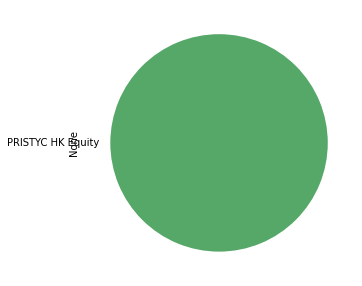

In [136]:
ef = EfficientFrontier(mu1, S1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.3%
Annual volatility: 8.0%
Sharpe Ratio: 0.04


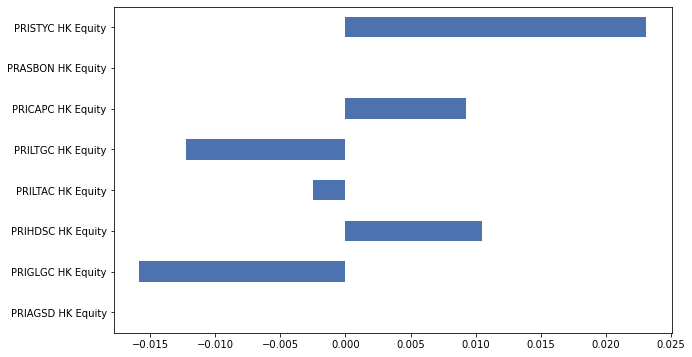

In [137]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
1.064445180226913
Portfolio return compared to train set (+- %):
-1.2479881087253766
Percentage change compared to train set (+- %):
-53.96861023786815
Compare to benchmark (+- %):
0.415445180226913


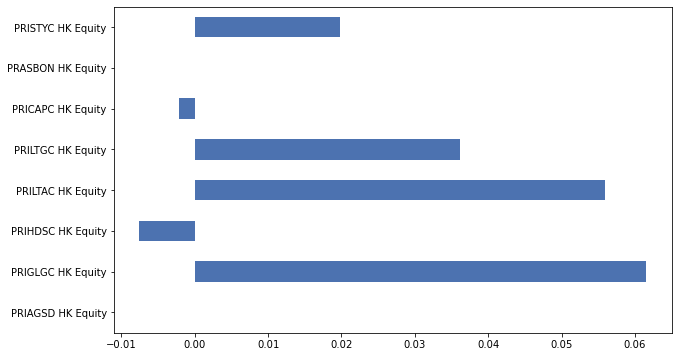

In [138]:
#calculate the asset returns in our portfolio.
ret_data = tone.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff1 = (sum(port_ret) - ret)*100
print(diff1)
print("Percentage change compared to train set (+- %):")
perch1 = diff1/ret
print(perch1)
compare1=((sum(port_ret)*100)-0.649)
print("Compare to benchmark (+- %):")
print(compare1)

tmu1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)


## 1st five-year Backtesting (for Function 1a)
### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 1.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


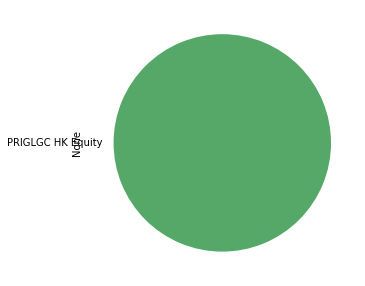

In [139]:
ef = EfficientFrontier(mu1_1, S1_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.7%
Annual volatility: 11.4%
Sharpe Ratio: 0.06


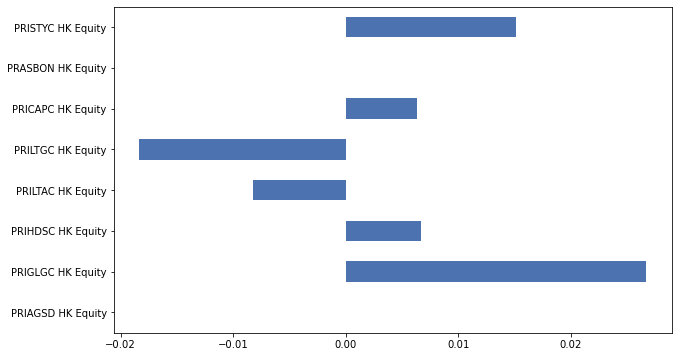

In [140]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu1_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
10.99792258665354
Portfolio return compared to train set (+- %):
8.324747346088955
Percentage change compared to train set (+- %):
311.417942967732
Compare to benchmark (+- %):
10.34892258665354


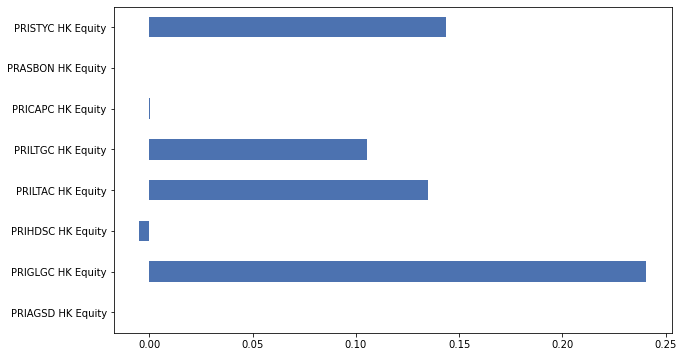

In [141]:
#calculate the asset returns in our portfolio.
ret_data = tone1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff1_1 = (sum(port_ret) - ret)*100
print(diff1_1)
print("Percentage change compared to train set (+- %):")
perch1_1 = diff1_1/ret
print(perch1_1)
compare1_1=((sum(port_ret)*100)-0.649)
print("Compare to benchmark (+- %):")
print(compare1_1)

tmu1_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 2nd five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.46005), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.07405), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.4659)])
Performance of function 1a portfolio in train period:


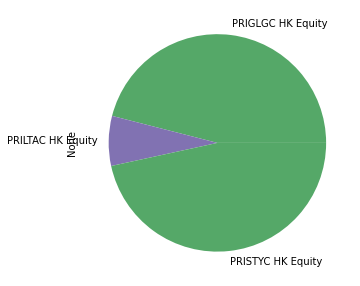

In [142]:
ef = EfficientFrontier(mu2, S2)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 6.7%
Annual volatility: 5.9%
Sharpe Ratio: 0.78


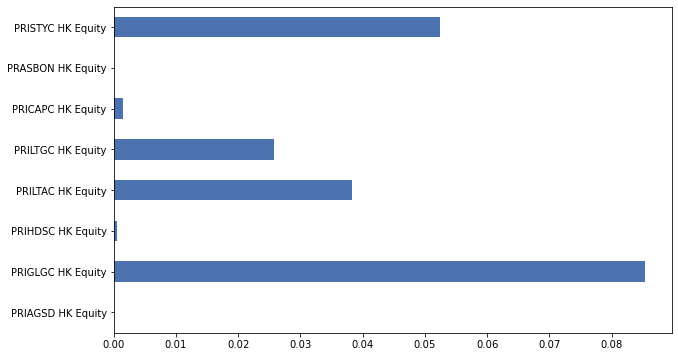

In [143]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu2.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
0.8207220913353223
Portfolio return compared to train set (+- %):
-5.830843401934241
Percentage change compared to train set (+- %):
-87.66121911953245
Compare to benchmark (+- %):
-0.4032779086646777


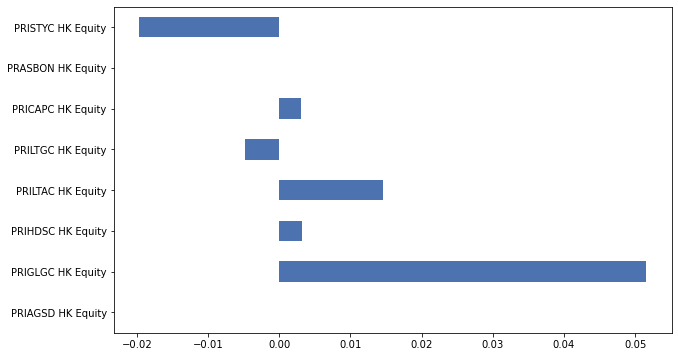

In [144]:
#calculate the asset returns in our portfolio.
ret_data = ttwo.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff2 = (sum(port_ret) - ret)*100
print(diff2)
print("Percentage change compared to train set (+- %):")
perch2 = diff2/ret
print(perch2)
compare2=((sum(port_ret)*100)-1.224)
print("Compare to benchmark (+- %):")
print(compare2)

tmu2.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)


## 2nd five-year Backtesting (for Function 1a)
### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.40727), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0926), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.50013)])
Performance of function 1a portfolio in train period:


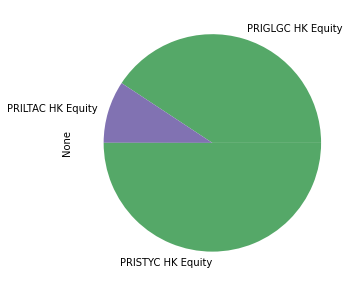

In [145]:
ef = EfficientFrontier(mu2_1, S2_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 5.9%
Annual volatility: 5.5%
Sharpe Ratio: 0.70


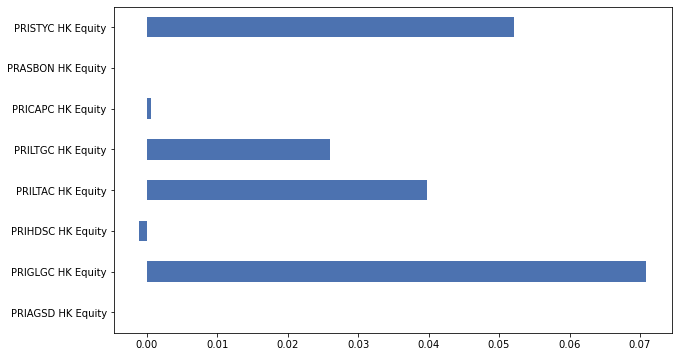

In [146]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu2_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
7.774794584893711
Portfolio return compared to train set (+- %):
1.9119010796256872
Percentage change compared to train set (+- %):
32.6101962777897
Compare to benchmark (+- %):
7.125794584893711


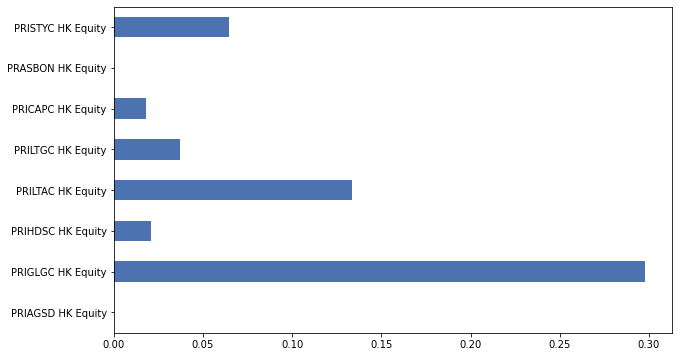

In [147]:
#calculate the asset returns in our portfolio.
ret_data = ttwo1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff2_1 = (sum(port_ret) - ret)*100
print(diff2_1)
print("Percentage change compared to train set (+- %):")
perch2_1 = diff2_1/ret
print(perch2_1)
compare2_1=((sum(port_ret)*100)-0.649)
print("Compare to benchmark (+- %):")
print(compare2_1)

tmu2_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 3rd five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.56002), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.06583), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.37415)])
Performance of function 1a portfolio in train period:


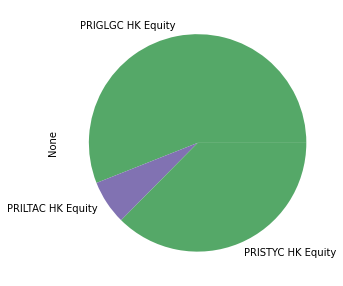

In [148]:
ef = EfficientFrontier(mu3, S3)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 12.7%
Annual volatility: 5.9%
Sharpe Ratio: 1.81


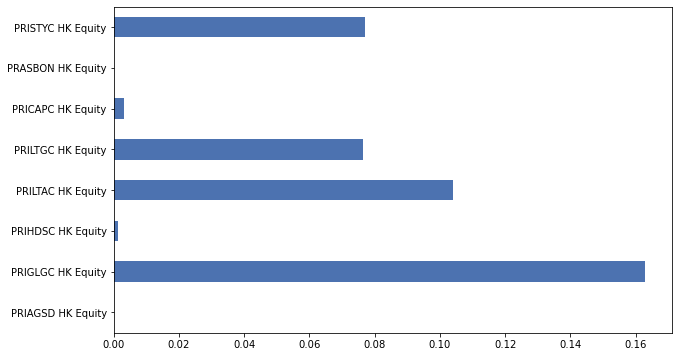

In [149]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu3.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
2.6258401162561174
Portfolio return compared to train set (+- %):
-10.058726834469534
Percentage change compared to train set (+- %):
-79.29893762667318
Compare to benchmark (+- %):
-0.8771598837438828


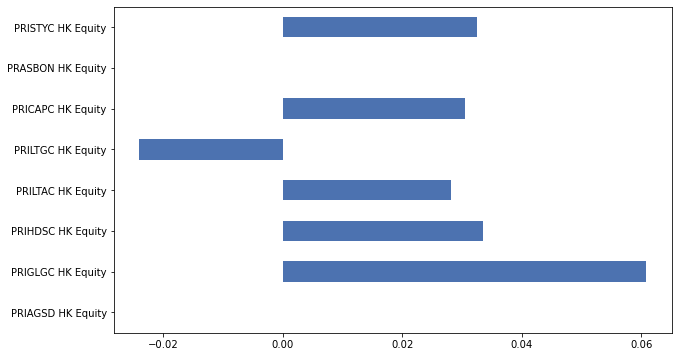

In [150]:
#calculate the asset returns in our portfolio.
ret_data = tthree.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff3 = (sum(port_ret) - ret)*100
print(diff3)
print("Percentage change compared to train set (+- %):")
perch3 = diff3/ret
print(perch3)
compare3=((sum(port_ret)*100)-3.503)
print("Compare to benchmark (+- %):")
print(compare3)

tmu3.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 3rd five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.65142), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.03012), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.31846)])
Performance of function 1a portfolio in train period:


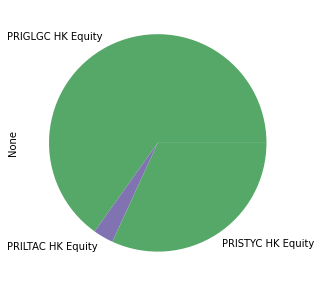

In [151]:
ef = EfficientFrontier(mu3_1, S3_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 13.3%
Annual volatility: 5.8%
Sharpe Ratio: 1.95


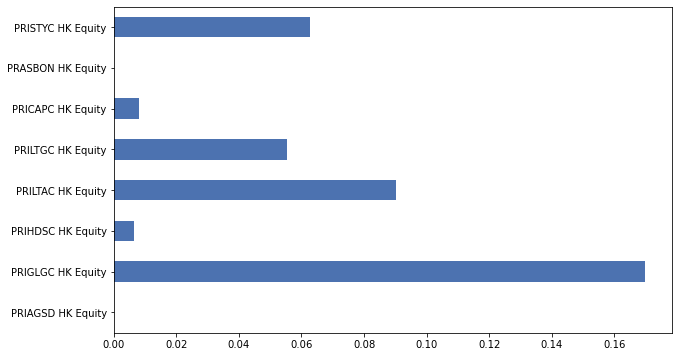

In [152]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu3_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
11.251749890115468
Portfolio return compared to train set (+- %):
-2.082778016407823
Percentage change compared to train set (+- %):
-15.619435731121172
Compare to benchmark (+- %):
7.748749890115468


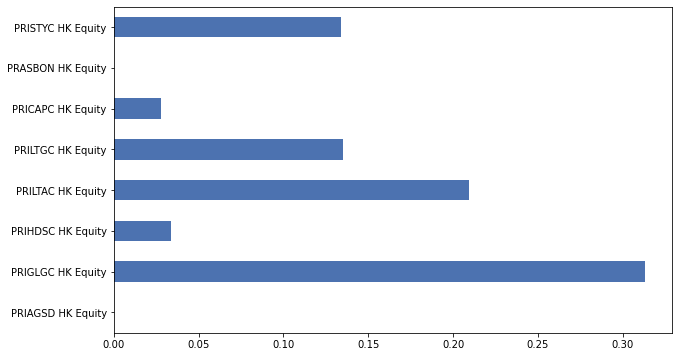

In [153]:
#calculate the asset returns in our portfolio.
ret_data = tthree1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff3_1 = (sum(port_ret) - ret)*100
print(diff3_1)
print("Percentage change compared to train set (+- %):")
perch3_1 = diff3_1/ret
print(perch3_1)
compare3_1=((sum(port_ret)*100)-3.503)
print("Compare to benchmark (+- %):")
print(compare3_1)

tmu3_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 4th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.6386), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.02752), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.33388)])
Performance of function 1a portfolio in train period:


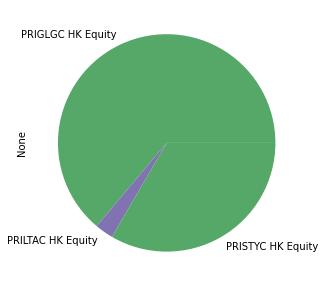

In [154]:
ef = EfficientFrontier(mu4, S4)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 12.9%
Annual volatility: 5.6%
Sharpe Ratio: 1.95


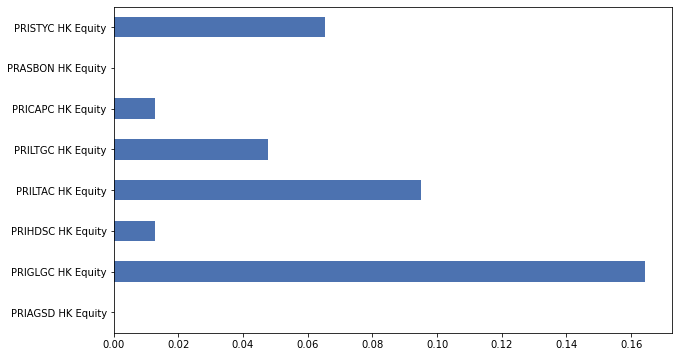

In [155]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu4.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
7.1842732844845045
Portfolio return compared to train set (+- %):
-5.750101854463615
Percentage change compared to train set (+- %):
-44.45596940472873
Compare to benchmark (+- %):
4.421273284484505


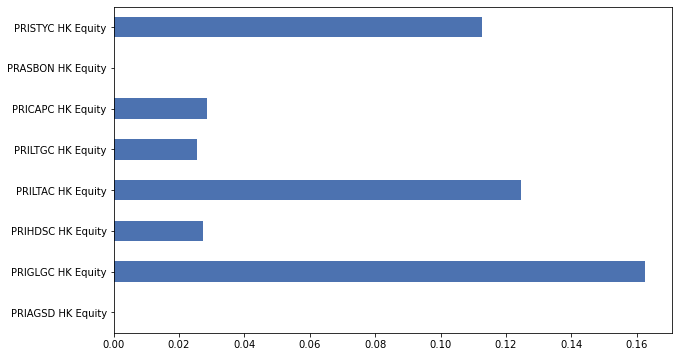

In [156]:
#calculate the asset returns in our portfolio.
ret_data = tfour.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff4 = (sum(port_ret) - ret)*100
print(diff4)
print("Percentage change compared to train set (+- %):")
perch4 = diff4/ret
print(perch4)
compare4=((sum(port_ret)*100)-2.763)
print("Compare to benchmark (+- %):")
print(compare4)

tmu4.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 4th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.61735), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0155), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.36715)])
Performance of function 1a portfolio in train period:


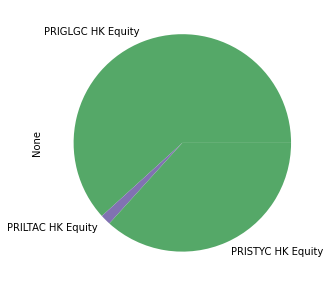

In [157]:
ef = EfficientFrontier(mu4_1, S4_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 14.6%
Annual volatility: 5.6%
Sharpe Ratio: 2.22


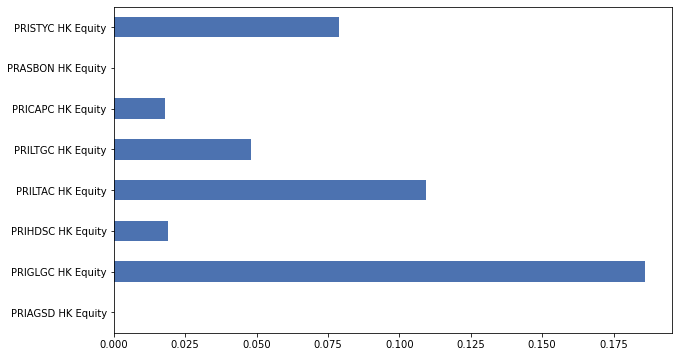

In [158]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu4_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
1.00204537024026
Portfolio return compared to train set (+- %):
-13.554531843942334
Percentage change compared to train set (+- %):
-93.11620200616971
Compare to benchmark (+- %):
-1.7609546297597398


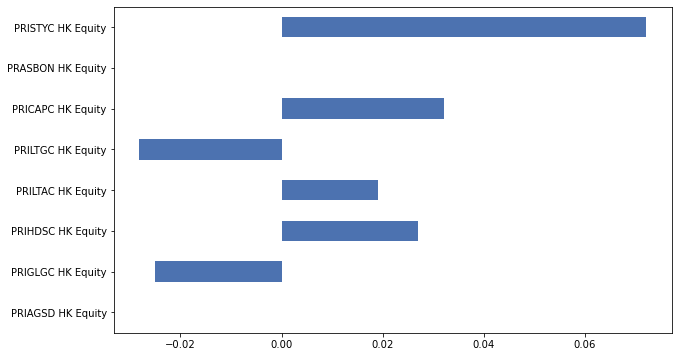

In [159]:
#calculate the asset returns in our portfolio.
ret_data = tfour1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff4_1 = (sum(port_ret) - ret)*100
print(diff4_1)
print("Percentage change compared to train set (+- %):")
perch4_1 = diff4_1/ret
print(perch4_1)
compare4_1=((sum(port_ret)*100)-2.763)
print("Compare to benchmark (+- %):")
print(compare4_1)

tmu4_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 5th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.50291), ('PRIHDSC HK Equity', 0.06384), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.05338), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.37987)])
Performance of function 1a portfolio in train period:


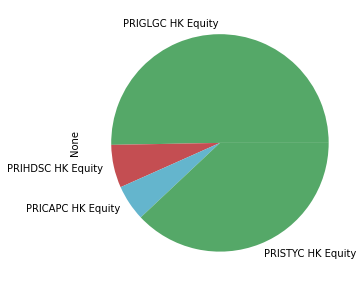

In [160]:
ef = EfficientFrontier(mu5, S5)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 10.5%
Annual volatility: 5.7%
Sharpe Ratio: 1.50


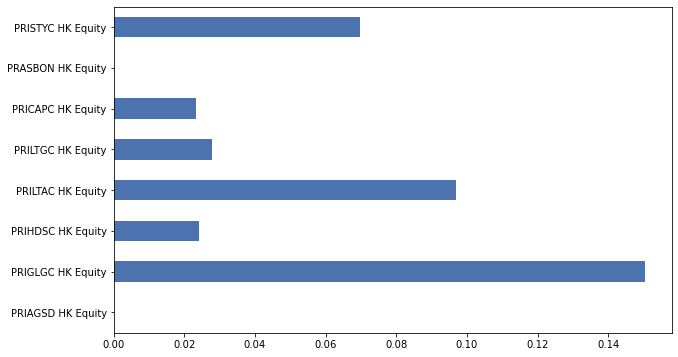

In [161]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu5.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
-10.462880511795968
Portfolio return compared to train set (+- %):
-20.95499183240642
Percentage change compared to train set (+- %):
-199.72140203319168
Compare to benchmark (+- %):
-9.615880511795968


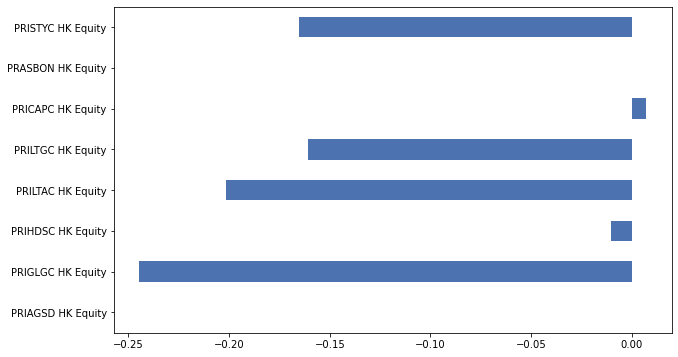

In [162]:
#calculate the asset returns in our portfolio.
ret_data = tfive.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff5 = (sum(port_ret) - ret)*100
print(diff5)
print("Percentage change compared to train set (+- %):")
perch5 = diff5/ret
print(perch5)
compare5=((sum(port_ret)*100)-(-0.847))
print("Compare to benchmark (+- %):")
print(compare5)

tmu5.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 5th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.46026), ('PRIHDSC HK Equity', 0.05383), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.16192), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.32399)])
Performance of function 1a portfolio in train period:


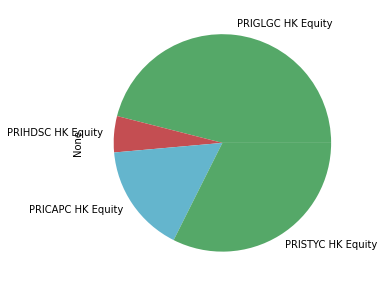

In [163]:
ef = EfficientFrontier(mu5_1, S5_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 5.7%
Annual volatility: 5.7%
Sharpe Ratio: 0.65


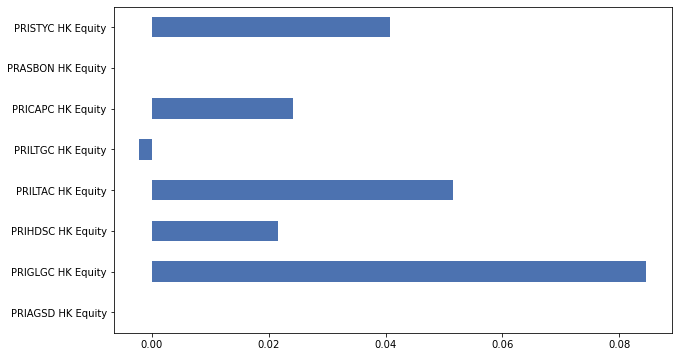

In [164]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu5_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
-12.724817411069731
Portfolio return compared to train set (+- %):
-18.44619987958714
Percentage change compared to train set (+- %):
-322.4080889730682
Compare to benchmark (+- %):
-11.877817411069731


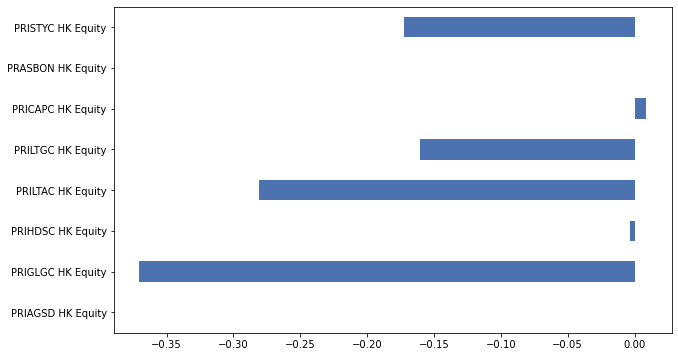

In [165]:
#calculate the asset returns in our portfolio.
ret_data = tfive1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff5_1 = (sum(port_ret) - ret)*100
print(diff5_1)
print("Percentage change compared to train set (+- %):")
perch5_1 = diff5_1/ret
print(perch5_1)
compare5_1=((sum(port_ret)*100)-(-0.847))
print("Compare to benchmark (+- %):")
print(compare5_1)

tmu5_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 6th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 1.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


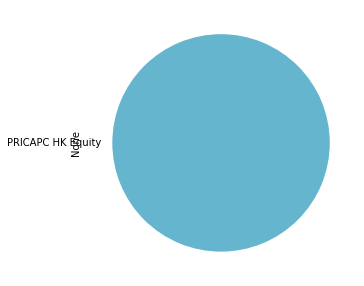

In [166]:
ef = EfficientFrontier(mu6, S6)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.3%
Annual volatility: 0.9%
Sharpe Ratio: 0.29


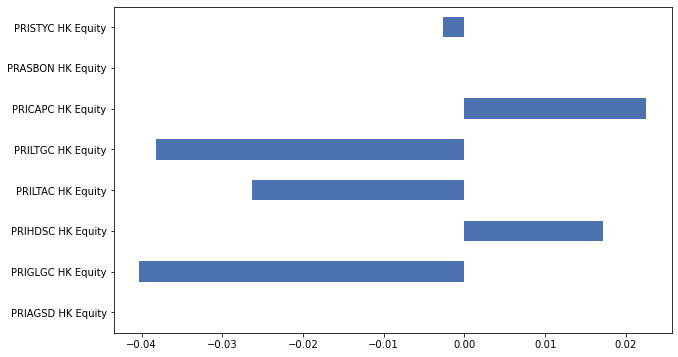

In [167]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu6.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
-0.0026787866738042787
Portfolio return compared to train set (+- %):
-2.256503682497002
Percentage change compared to train set (+- %):
-100.11885513727213
Compare to benchmark (+- %):
0.07032121332619572


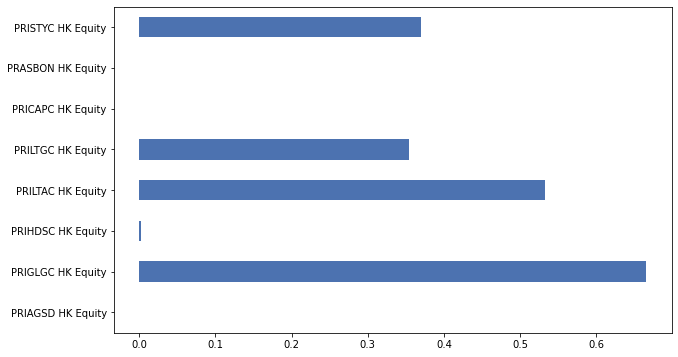

In [168]:
#calculate the asset returns in our portfolio.
ret_data = tsix.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff6 = (sum(port_ret) - ret)*100
print(diff6)
print("Percentage change compared to train set (+- %):")
perch6 = diff6/ret
print(perch6)
compare6=((sum(port_ret)*100)-(-0.073))
print("Compare to benchmark (+- %):")
print(compare6)

tmu6.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 6th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.26101), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.73899)])
Performance of function 1a portfolio in train period:


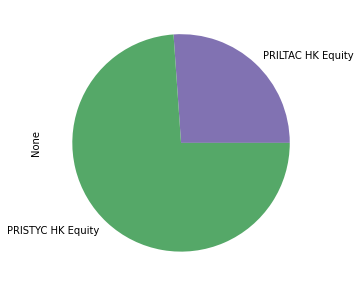

In [169]:
ef = EfficientFrontier(mu6_1, S6_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.5%
Annual volatility: 7.2%
Sharpe Ratio: 0.35


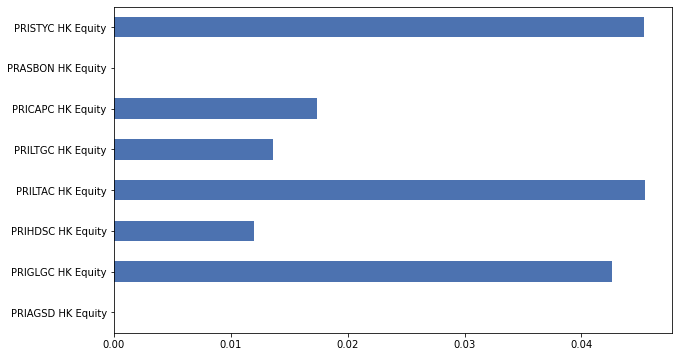

In [170]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu6_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

### Comparison - Performance of Portfolio during the Validation period.

Portfolio return in test year(%):
1.2226088723112063
Portfolio return compared to train set (+- %):
-3.3154566444328
Percentage change compared to train set (+- %):
-73.05880957865921
Compare to benchmark (+- %):
1.2956088723112062


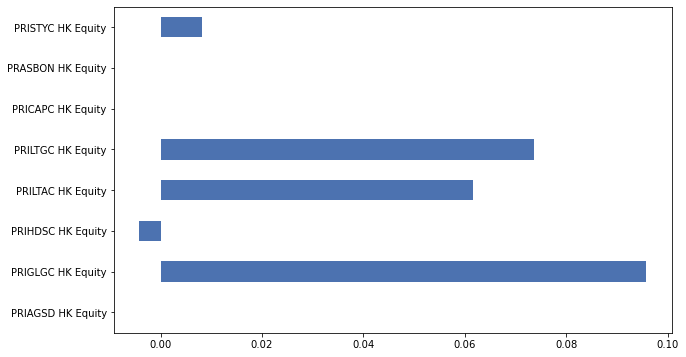

In [171]:
#calculate the asset returns in our portfolio.
ret_data = tsix1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff6_1 = (sum(port_ret) - ret)*100
print(diff6_1)
print("Percentage change compared to train set (+- %):")
perch6_1 = diff6_1/ret
print(perch6_1)
compare6_1=((sum(port_ret)*100)-(-0.073))
print("Compare to benchmark (+- %):")
print(compare6_1)

tmu6_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 7th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 1.0)])
Performance of function 1a portfolio in train period:


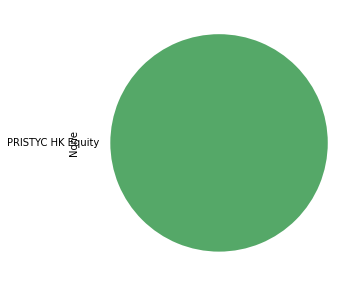

In [172]:
ef = EfficientFrontier(mu7, S7)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 2.9%
Annual volatility: 8.3%
Sharpe Ratio: 0.11


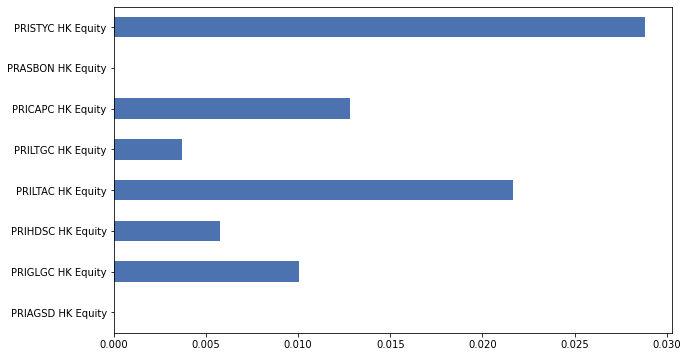

In [173]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu7.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
7.127847658509601
Portfolio return compared to train set (+- %):
4.245709096341366
Percentage change compared to train set (+- %):
147.31106797125383
Compare to benchmark (+- %):
7.712847658509601


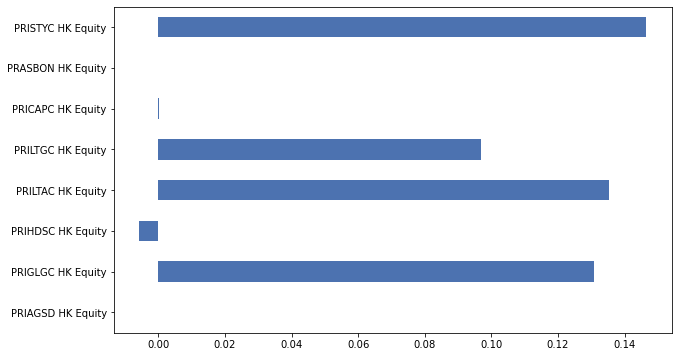

In [174]:
#calculate the asset returns in our portfolio.
ret_data = tseven.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff7 = (sum(port_ret) - ret)*100
print(diff7)
print("Percentage change compared to train set (+- %):")
perch7 = diff7/ret
print(perch7)
compare7=((sum(port_ret)*100)-(-0.585))
print("Compare to benchmark (+- %):")
print(compare7)

tmu7.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 7th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 1.0)])
Performance of function 1a portfolio in train period:


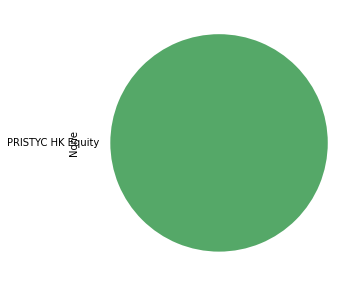

In [175]:
ef = EfficientFrontier(mu7_1, S7_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.0%
Annual volatility: 8.5%
Sharpe Ratio: 0.12


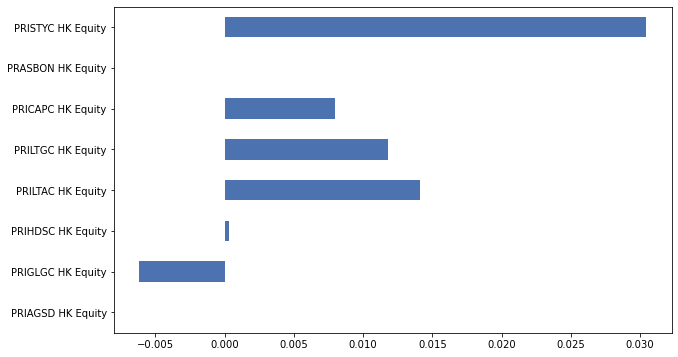

In [176]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu7_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
2.692104698739106
Portfolio return compared to train set (+- %):
-0.3536935381369011
Percentage change compared to train set (+- %):
-11.612507153450682
Compare to benchmark (+- %):
3.277104698739106


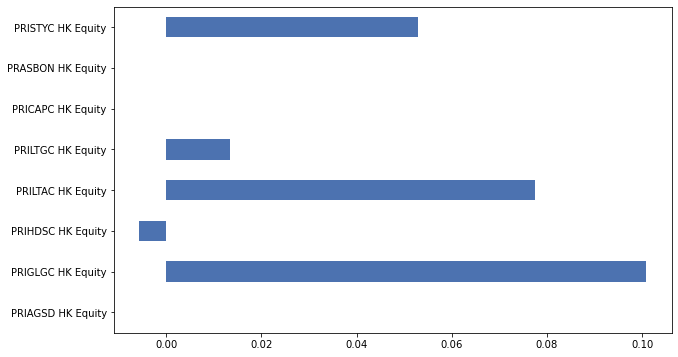

In [177]:
#calculate the asset returns in our portfolio.
ret_data = tseven1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff7_1 = (sum(port_ret) - ret)*100
print(diff7_1)
print("Percentage change compared to train set (+- %):")
perch7_1 = diff7_1/ret
print(perch7_1)
compare7_1=((sum(port_ret)*100)-(-0.585))
print("Compare to benchmark (+- %):")
print(compare7_1)

tmu7_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 8th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.28566), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.71434)])
Performance of function 1a portfolio in train period:


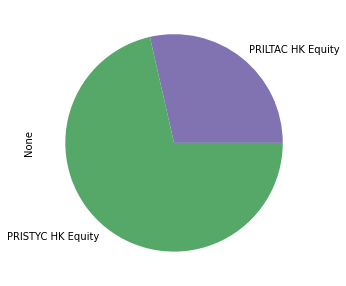

In [178]:
ef = EfficientFrontier(mu8, S8)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.0%
Annual volatility: 7.3%
Sharpe Ratio: 0.14


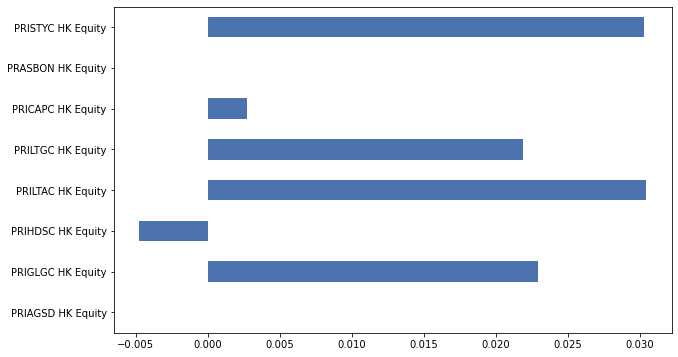

In [179]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu8.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-5.610830252828169
Portfolio return compared to train set (+- %):
-8.643191887023814
Percentage change compared to train set (+- %):
-285.03169904128146
Compare to benchmark (+- %):
-10.710830252828169


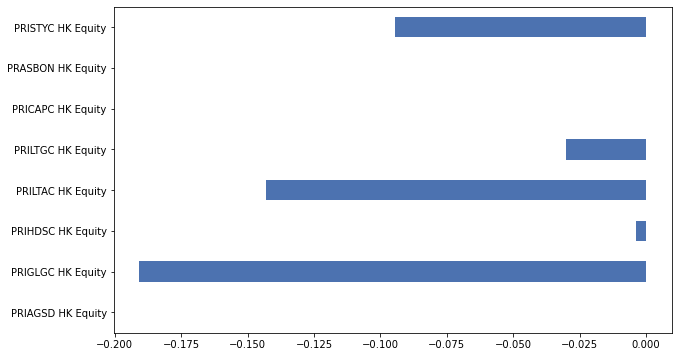

In [180]:
#calculate the asset returns in our portfolio.
ret_data = teight.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff8 = (sum(port_ret) - ret)*100
print(diff8)
print("Percentage change compared to train set (+- %):")
perch8 = diff8/ret
print(perch8)
compare8=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare8)

tmu8.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 8th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.83213), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.16787)])
Performance of function 1a portfolio in train period:


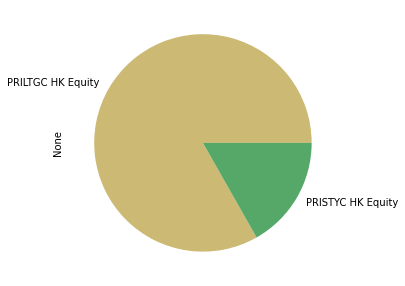

In [181]:
ef = EfficientFrontier(mu8_1, S8_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.9%
Annual volatility: 5.2%
Sharpe Ratio: 0.55


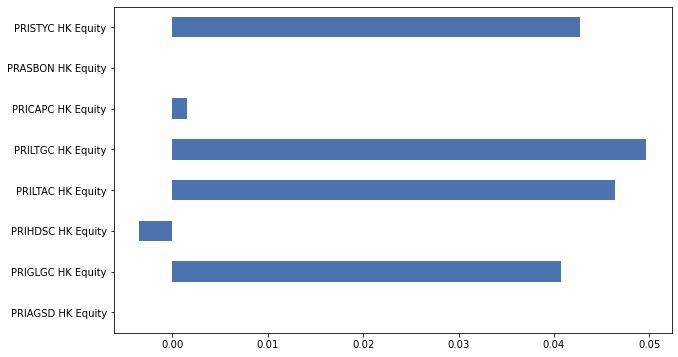

In [182]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu8_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
2.4209383979605286
Portfolio return compared to train set (+- %):
-2.429355826232866
Percentage change compared to train set (+- %):
-50.086772347029495
Compare to benchmark (+- %):
-2.679061602039471


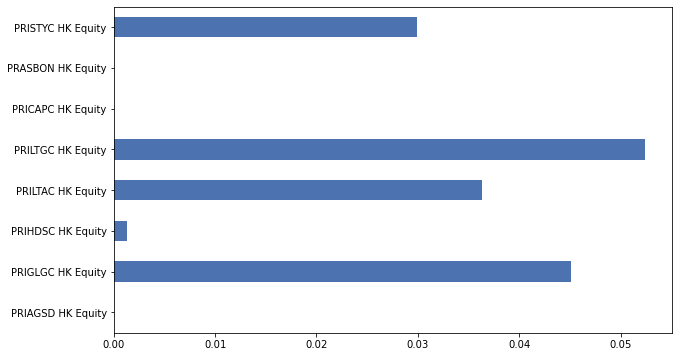

In [183]:
#calculate the asset returns in our portfolio.
ret_data = teight1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff8_1 = (sum(port_ret) - ret)*100
print(diff8_1)
print("Percentage change compared to train set (+- %):")
perch8_1 = diff8_1/ret
print(perch8_1)
compare8_1=((sum(port_ret)*100)-5.1)
print("Compare to benchmark (+- %):")
print(compare8_1)

tmu8_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 9th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.86875), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.13125)])
Performance of function 1a portfolio in train period:


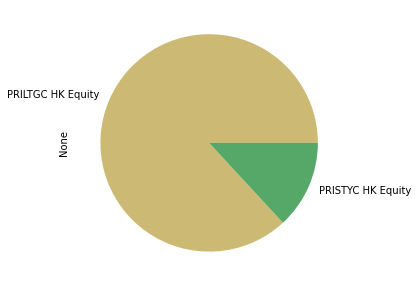

In [184]:
ef = EfficientFrontier(mu9, S9)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 8.5%
Annual volatility: 3.6%
Sharpe Ratio: 1.79


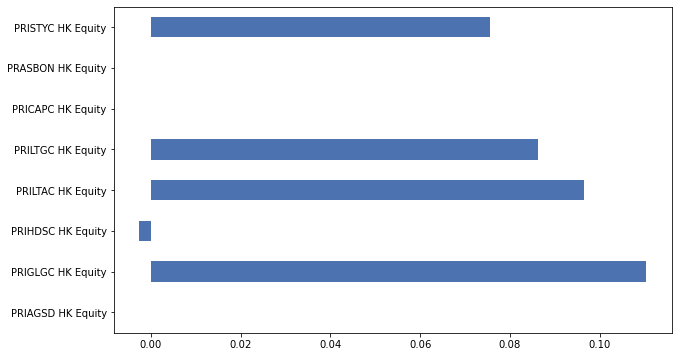

In [185]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu9.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
4.50636494294034
Portfolio return compared to train set (+- %):
-3.980267258145039
Percentage change compared to train set (+- %):
-46.90043310273293
Compare to benchmark (+- %):
4.14236494294034


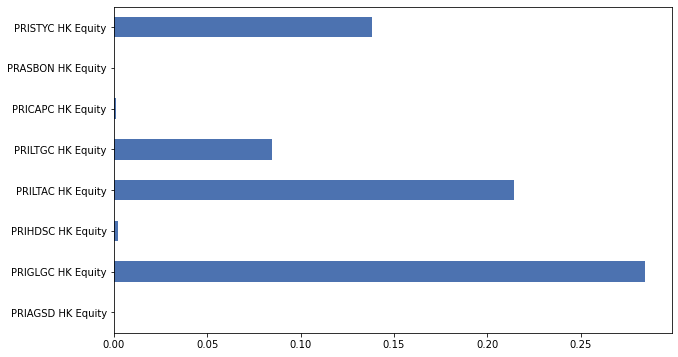

In [186]:
#calculate the asset returns in our portfolio.
ret_data = tnine.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff9 = (sum(port_ret) - ret)*100
print(diff9)
print("Percentage change compared to train set (+- %):")
perch9 = diff9/ret
print(perch9)
compare9=((sum(port_ret)*100)-0.364)
print("Compare to benchmark (+- %):")
print(compare9)

tmu9.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 9th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.88866), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.11134)])
Performance of function 1a portfolio in train period:


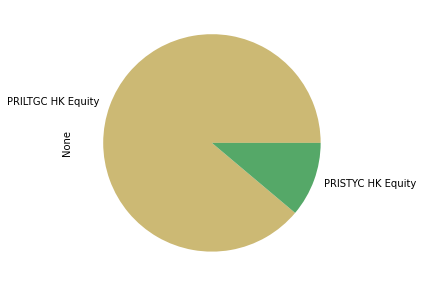

In [187]:
ef = EfficientFrontier(mu9_1, S9_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.4%
Annual volatility: 3.1%
Sharpe Ratio: 0.80


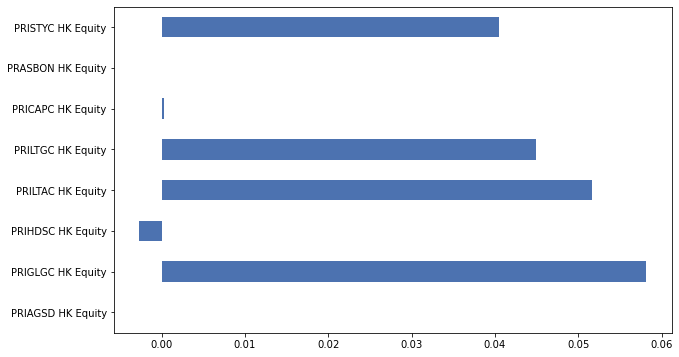

In [188]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu9_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-3.276508040777832
Portfolio return compared to train set (+- %):
-7.718123122733532
Percentage change compared to train set (+- %):
-173.76839235999586
Compare to benchmark (+- %):
-3.640508040777832


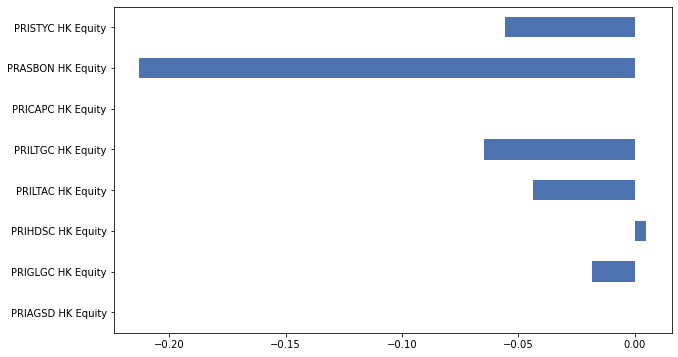

In [189]:
#calculate the asset returns in our portfolio.
ret_data = tnine1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff9_1 = (sum(port_ret) - ret)*100
print(diff9_1)
print("Percentage change compared to train set (+- %):")
perch9_1 = diff9_1/ret
print(perch9_1)
compare9_1=((sum(port_ret)*100)-0.364)
print("Compare to benchmark (+- %):")
print(compare9_1)

tmu9_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 10th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.37949), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.62051)])
Performance of function 1a portfolio in train period:


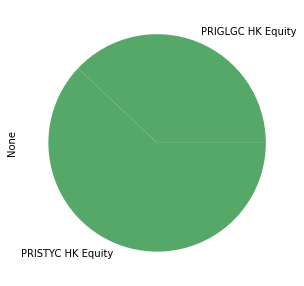

In [190]:
ef = EfficientFrontier(mu10, S10)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.6%
Annual volatility: 6.6%
Sharpe Ratio: 0.24


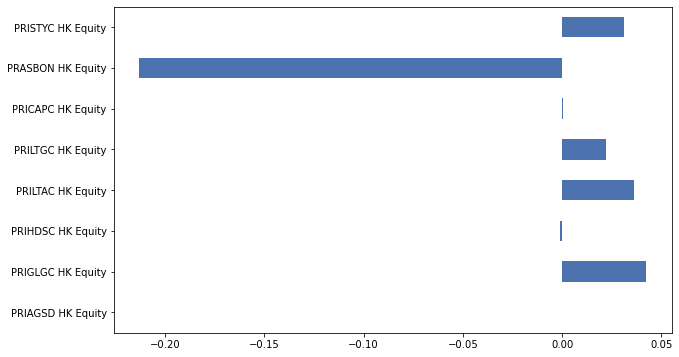

In [191]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu10.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
6.354281557262693
Portfolio return compared to train set (+- %):
2.798311288127392
Percentage change compared to train set (+- %):
78.6933263310959
Compare to benchmark (+- %):
6.310281557262694


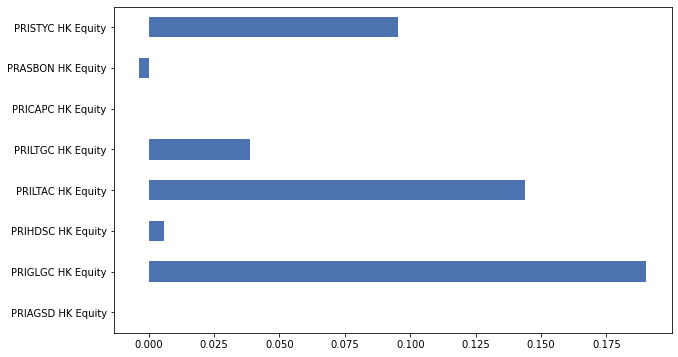

In [192]:
#calculate the asset returns in our portfolio.
ret_data = tten.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff10 = (sum(port_ret) - ret)*100
print(diff10)
print("Percentage change compared to train set (+- %):")
perch10 = diff10/ret
print(perch10)
compare10=((sum(port_ret)*100)-0.044)
print("Compare to benchmark (+- %):")
print(compare10)

tmu10.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 10th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.98747), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.01253)])
Performance of function 1a portfolio in train period:


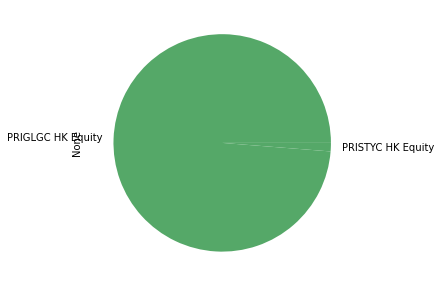

In [193]:
ef = EfficientFrontier(mu10_1, S10_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 5.4%
Annual volatility: 10.9%
Sharpe Ratio: 0.31


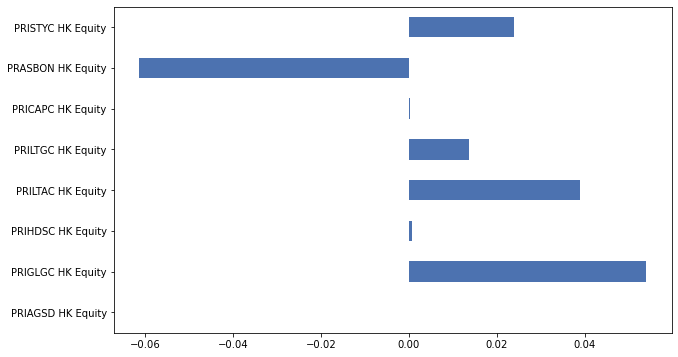

In [194]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu10_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
4.0252740701895435
Portfolio return compared to train set (+- %):
-1.3403049489786358
Percentage change compared to train set (+- %):
-24.979688942991693
Compare to benchmark (+- %):
3.9812740701895435


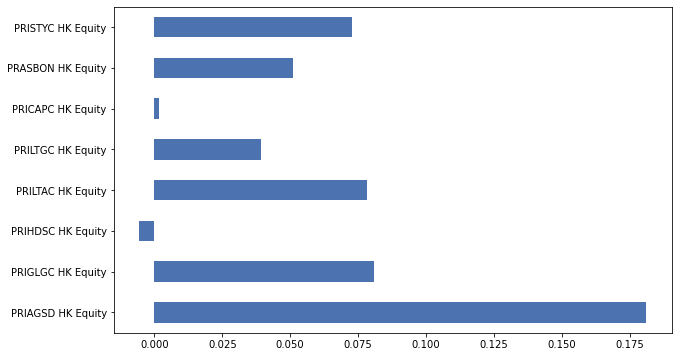

In [195]:
#calculate the asset returns in our portfolio.
ret_data = tten1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff10_1 = (sum(port_ret) - ret)*100
print(diff10_1)
print("Percentage change compared to train set (+- %):")
perch10_1 = diff10_1/ret
print(perch10_1)
compare10_1=((sum(port_ret)*100)-0.044)
print("Compare to benchmark (+- %):")
print(compare10_1)

tmu10_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 11th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.99642), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.00358)])
Performance of function 1a portfolio in train period:


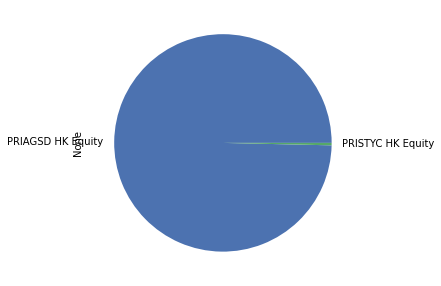

In [196]:
ef = EfficientFrontier(mu11, S11)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 18.1%
Annual volatility: 2.0%
Sharpe Ratio: 8.22


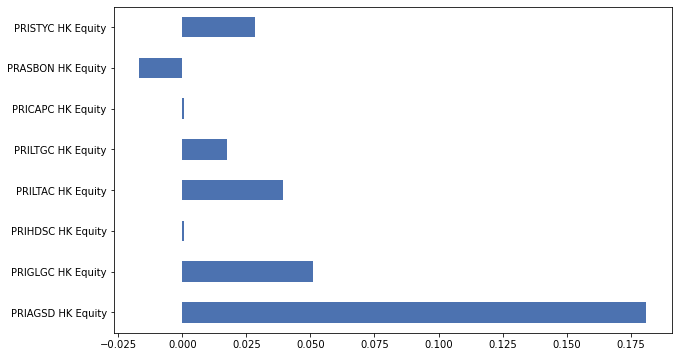

In [197]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu11.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-0.9564175437455756
Portfolio return compared to train set (+- %):
-19.016578608473274
Percentage change compared to train set (+- %):
-105.29573097558637
Compare to benchmark (+- %):
-1.3304175437455756


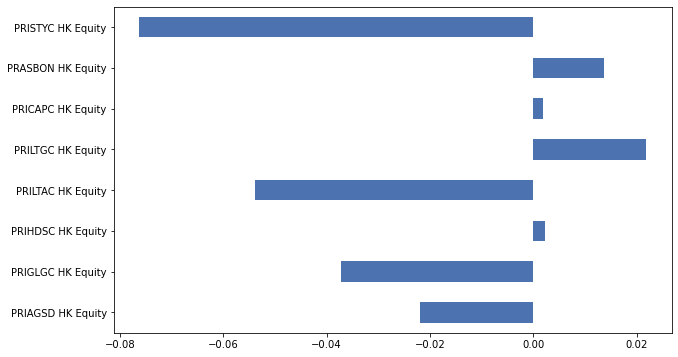

In [198]:
#calculate the asset returns in our portfolio.
ret_data = televen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff11 = (sum(port_ret) - ret)*100
print(diff11)
print("Percentage change compared to train set (+- %):")
perch11 = diff11/ret
print(perch11)
compare11=((sum(port_ret)*100)-0.374)
print("Compare to benchmark (+- %):")
print(compare11)

tmu11.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 11th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.28226), ('PRIGLGC HK Equity', 0.40793), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.30981)])
Performance of function 1a portfolio in train period:


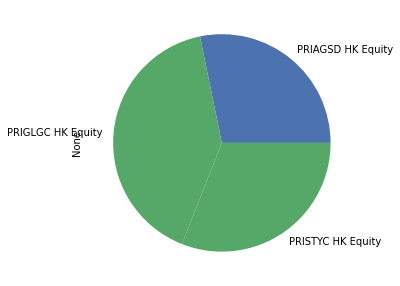

In [199]:
ef = EfficientFrontier(mu11_1, S11_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 5.9%
Annual volatility: 4.3%
Sharpe Ratio: 0.91


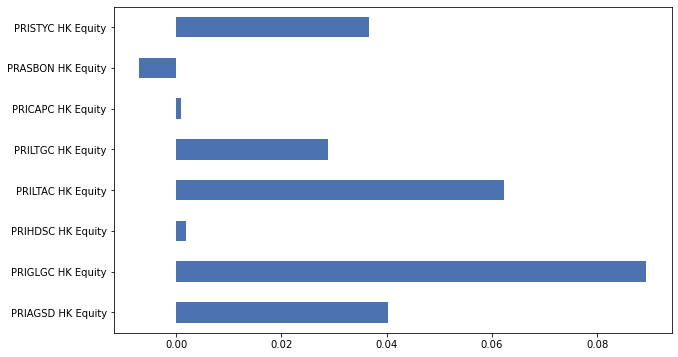

In [200]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu11_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
1.341588724909623
Portfolio return compared to train set (+- %):
-4.573094395231434
Percentage change compared to train set (+- %):
-77.31765679312288
Compare to benchmark (+- %):
0.967588724909623


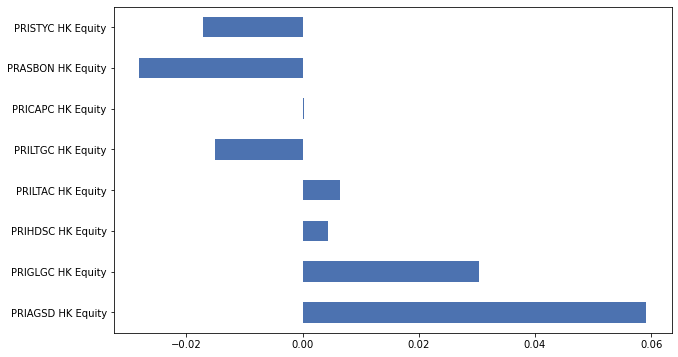

In [201]:
#calculate the asset returns in our portfolio.
ret_data = televen1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff11_1 = (sum(port_ret) - ret)*100
print(diff11_1)
print("Percentage change compared to train set (+- %):")
perch11_1 = diff11_1/ret
print(perch11_1)
compare11_1=((sum(port_ret)*100)-0.374)
print("Compare to benchmark (+- %):")
print(compare11_1)

tmu11_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 12th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.81216), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.18784)])
Performance of function 1a portfolio in train period:


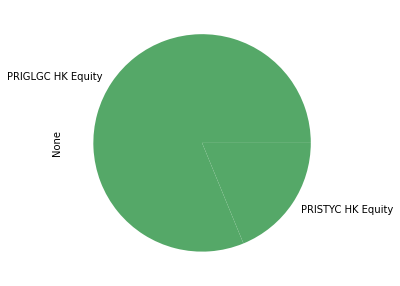

In [202]:
ef = EfficientFrontier(mu12, S12)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 8.0%
Annual volatility: 6.5%
Sharpe Ratio: 0.93


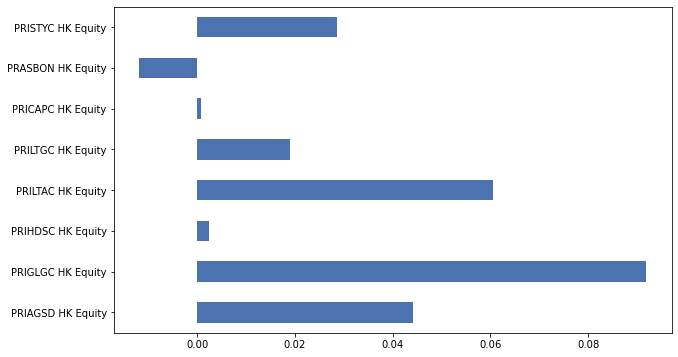

In [203]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu12.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-8.605105034674477
Portfolio return compared to train set (+- %):
-16.605908487438384
Percentage change compared to train set (+- %):
-207.55301121291527
Compare to benchmark (+- %):
-8.218105034674476


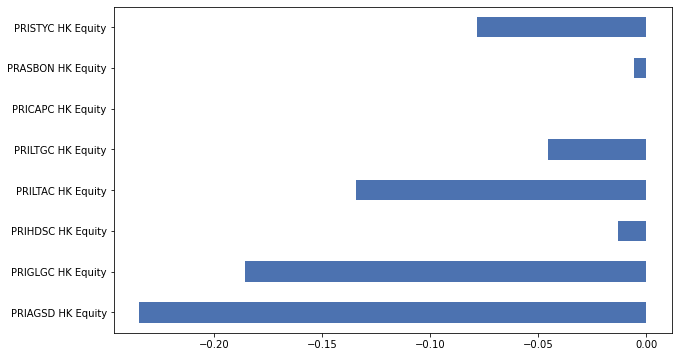

In [204]:
#calculate the asset returns in our portfolio.
ret_data = ttwelve.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff12 = (sum(port_ret) - ret)*100
print(diff12)
print("Percentage change compared to train set (+- %):")
perch12 = diff12/ret
print(perch12)
compare12=((sum(port_ret)*100)-(-0.387))
print("Compare to benchmark (+- %):")
print(compare12)

tmu12.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 12th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

In [205]:
ef = EfficientFrontier(mu12_1, S12_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

OptimizationError: Please check your objectives/constraints or use a different solver.

### Comparison - Performance of Portfolio during the Train period.

In [206]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu12_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

ValueError: Weights is None

Portfolio return in test year(%):
8.921279653418495
Portfolio return compared to train set (+- %):
0.9204762006545866
Percentage change compared to train set (+- %):
11.504797063057518
Compare to benchmark (+- %):
9.308279653418495


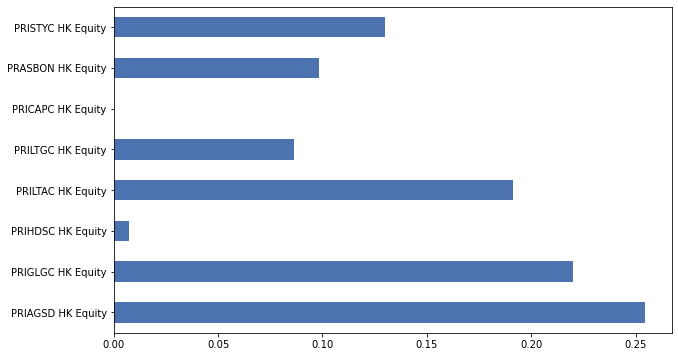

In [207]:
#calculate the asset returns in our portfolio.
ret_data = ttwelve1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff12_1 = (sum(port_ret) - ret)*100
print(diff12_1)
print("Percentage change compared to train set (+- %):")
perch12_1 = diff12_1/ret
print(perch12_1)
compare12_1=((sum(port_ret)*100)-(-0.387))
print("Compare to benchmark (+- %):")
print(compare12_1)

tmu12_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 13th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 1.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


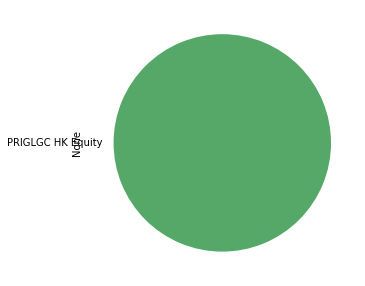

In [208]:
ef = EfficientFrontier(mu13, S13)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 3.4%
Annual volatility: 8.7%
Sharpe Ratio: 0.16


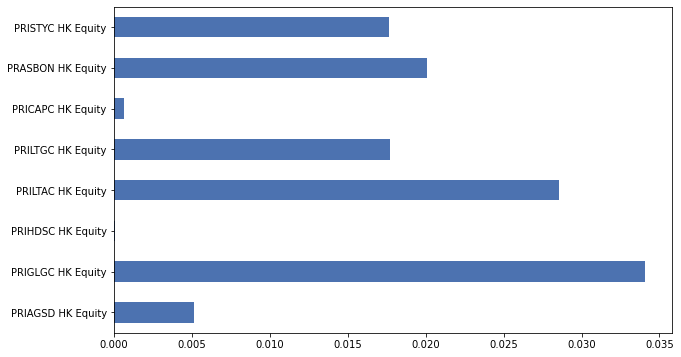

In [209]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu13.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
2.5577598099378984
Portfolio return compared to train set (+- %):
-0.8501987502252173
Percentage change compared to train set (+- %):
-24.94744977722159
Compare to benchmark (+- %):
2.2627598099378985


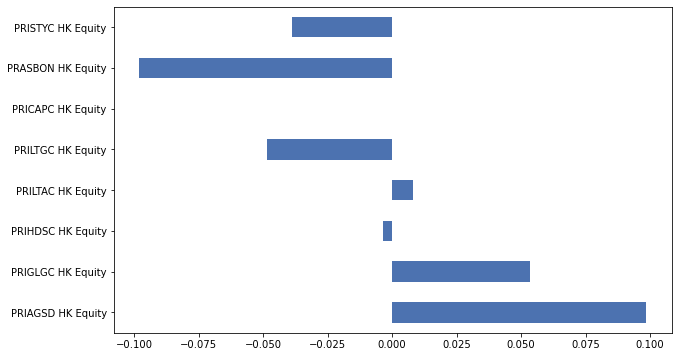

In [210]:
#calculate the asset returns in our portfolio.
ret_data = tthirteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff13 = (sum(port_ret) - ret)*100
print(diff13)
print("Percentage change compared to train set (+- %):")
perch13 = diff13/ret
print(perch13)
compare13=((sum(port_ret)*100)-0.295)
print("Compare to benchmark (+- %):")
print(compare13)

tmu13.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 13th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

In [211]:
ef = EfficientFrontier(mu13_1, S13_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

OptimizationError: Please check your objectives/constraints or use a different solver.

### Comparison - Performance of Portfolio during the Train period.

In [212]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu13_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

ValueError: Weights is None

Portfolio return in test year(%):
11.747661376093632
Portfolio return compared to train set (+- %):
8.339702815930517
Percentage change compared to train set (+- %):
-24.94744977722159
Compare to benchmark (+- %):
11.452661376093632


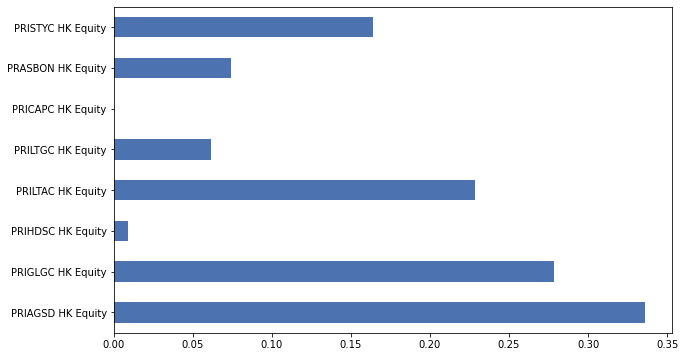

In [213]:
#calculate the asset returns in our portfolio.
ret_data = tthirteen1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff13_1 = (sum(port_ret) - ret)*100
print(diff13_1)
print("Percentage change compared to train set (+- %):")
perch13_1 = diff13_1/ret
print(perch13)
compare13_1=((sum(port_ret)*100)-0.295)
print("Compare to benchmark (+- %):")
print(compare13_1)

tmu13_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 14th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 1.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.0)])
Performance of function 1a portfolio in train period:


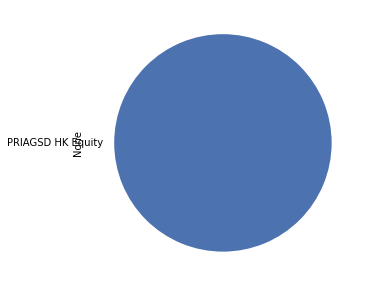

In [214]:
ef = EfficientFrontier(mu14, S14)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.8%
Annual volatility: 10.9%
Sharpe Ratio: 0.25


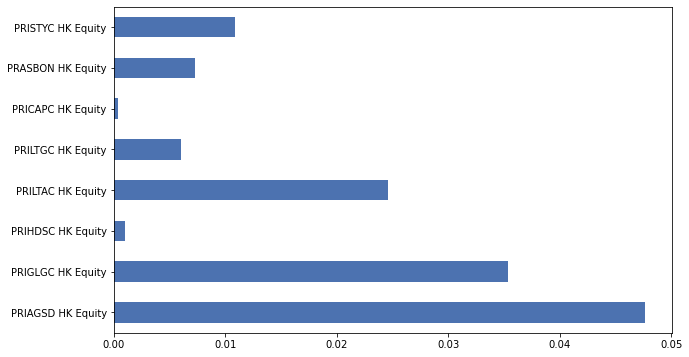

In [215]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu14.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
14.211672250667096
Portfolio return compared to train set (+- %):
9.447061762063502
Percentage change compared to train set (+- %):
198.27563626994902
Compare to benchmark (+- %):
8.024672250667095


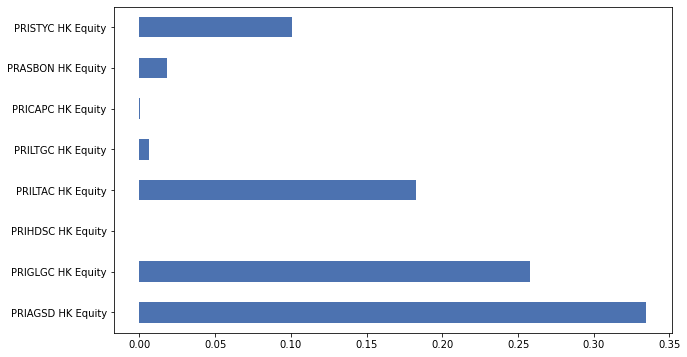

In [216]:
#calculate the asset returns in our portfolio.
ret_data = tfourteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff14 = (sum(port_ret) - ret)*100
print(diff14)
print("Percentage change compared to train set (+- %):")
perch14 = diff14 /ret
print(perch14)
compare14=((sum(port_ret)*100)-6.187)
print("Compare to benchmark (+- %):")
print(compare14)

tmu14.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 14th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.41889), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.58111)])
Performance of function 1a portfolio in train period:


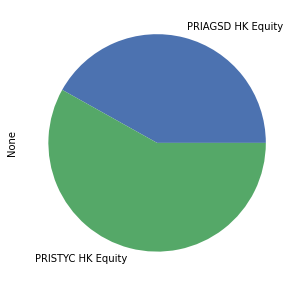

In [217]:
ef = EfficientFrontier(mu14_1, S14_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 7.0%
Annual volatility: 5.5%
Sharpe Ratio: 0.90


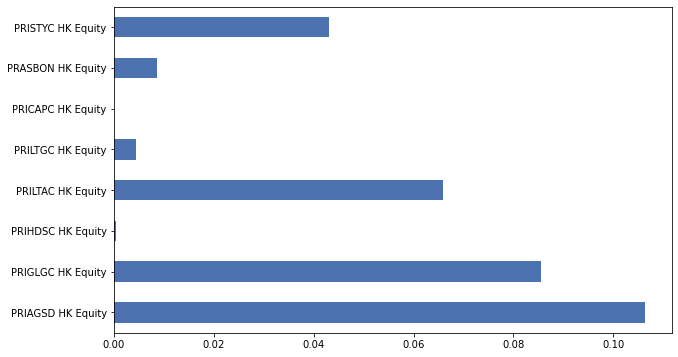

In [218]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu14_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-4.036024698769073
Portfolio return compared to train set (+- %):
-10.998401531409554
Percentage change compared to train set (+- %):
198.27563626994902
Compare to benchmark (+- %):
-10.223024698769073


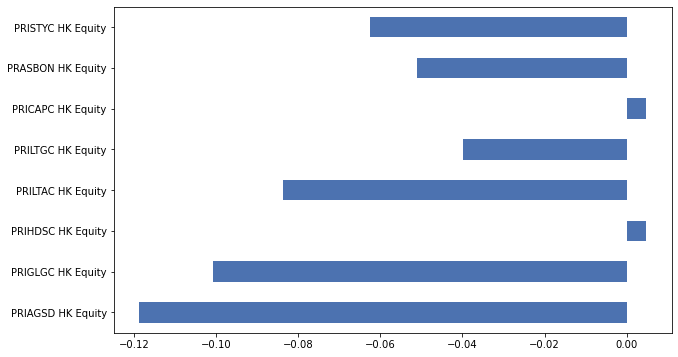

In [219]:
#calculate the asset returns in our portfolio.
ret_data = tfourteen1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff14_1 = (sum(port_ret) - ret)*100
print(diff14_1)
print("Percentage change compared to train set (+- %):")
perch14_1 = diff14_1 /ret
print(perch14)
compare14_1=((sum(port_ret)*100)-6.187)
print("Compare to benchmark (+- %):")
print(compare14_1)

tmu14_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 15th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.37686), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.62314)])
Performance of function 1a portfolio in train period:


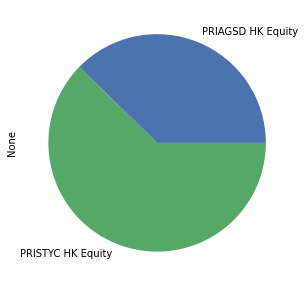

In [220]:
ef = EfficientFrontier(mu15, S15)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.9%
Annual volatility: 5.3%
Sharpe Ratio: 0.56


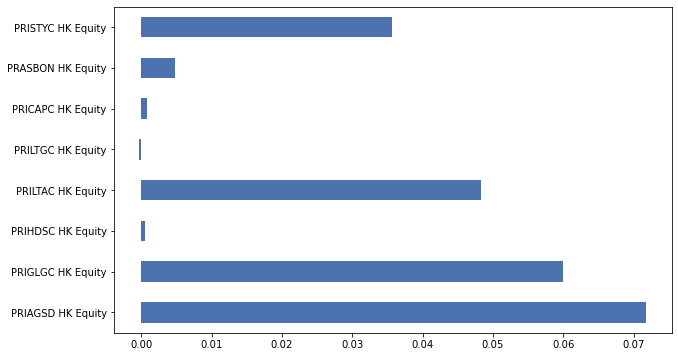

In [221]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu15.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
-4.138365669251112
Portfolio return compared to train set (+- %):
-9.068006916952125
Percentage change compared to train set (+- %):
-183.94861738024196
Compare to benchmark (+- %):
-7.347365669251111


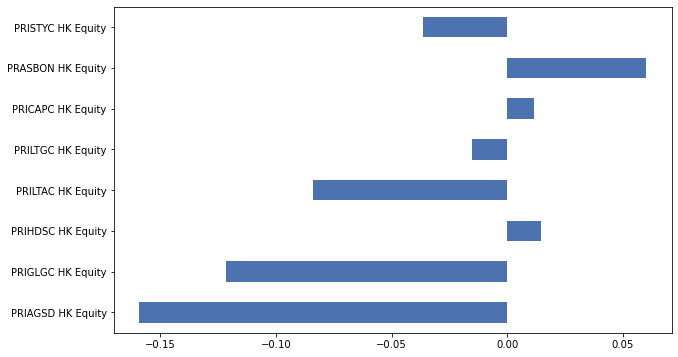

In [222]:
#calculate the asset returns in our portfolio.
ret_data = tfifteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff15 = (sum(port_ret) - ret)*100
print(diff15)
print("Percentage change compared to train set (+- %):")
perch15 = diff15/ret
print(perch15)
compare15=((sum(port_ret)*100)-3.209)
print("Compare to benchmark (+- %):")
print(compare15)

tmu15.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 15th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.40905), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.59095)])
Performance of function 1a portfolio in train period:


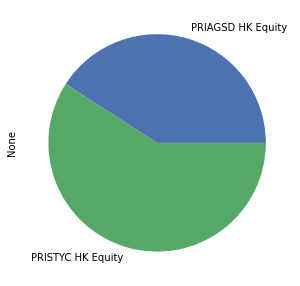

In [223]:
ef = EfficientFrontier(mu15_1, S15_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 6.2%
Annual volatility: 5.2%
Sharpe Ratio: 0.81


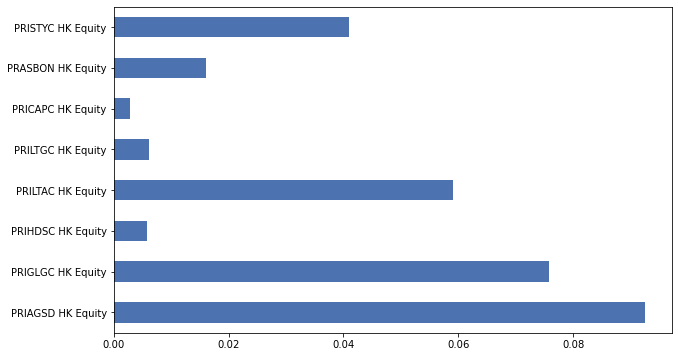

In [224]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu15_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
3.129478602360676
Portfolio return compared to train set (+- %):
-3.077144935473907
Percentage change compared to train set (+- %):
-183.94861738024196
Compare to benchmark (+- %):
-0.07952139763932387


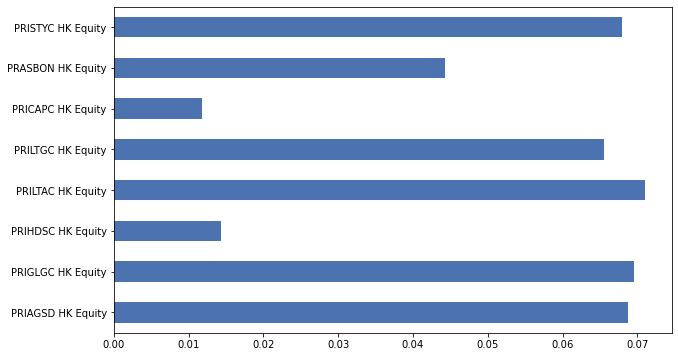

In [225]:
#calculate the asset returns in our portfolio.
ret_data = tfifteen1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff15_1 = (sum(port_ret) - ret)*100
print(diff15_1)
print("Percentage change compared to train set (+- %):")
perch15_1 = diff15_1/ret
print(perch15)
compare15_1=((sum(port_ret)*100)-3.209)
print("Compare to benchmark (+- %):")
print(compare15_1)

tmu15_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 16th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.49936), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.0), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.50064)])
Performance of function 1a portfolio in train period:


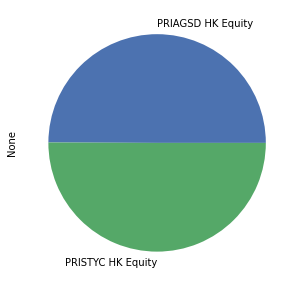

In [226]:
ef = EfficientFrontier(mu16, S16)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 5.2%
Annual volatility: 5.3%
Sharpe Ratio: 0.61


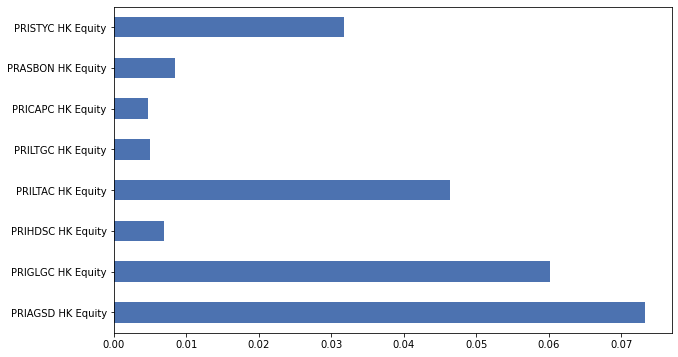

In [227]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu16.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
3.659767467401806
Portfolio return compared to train set (+- %):
-1.5886703123285093
Percentage change compared to train set (+- %):
-30.269394036907897
Compare to benchmark (+- %):
-3.000232532598194


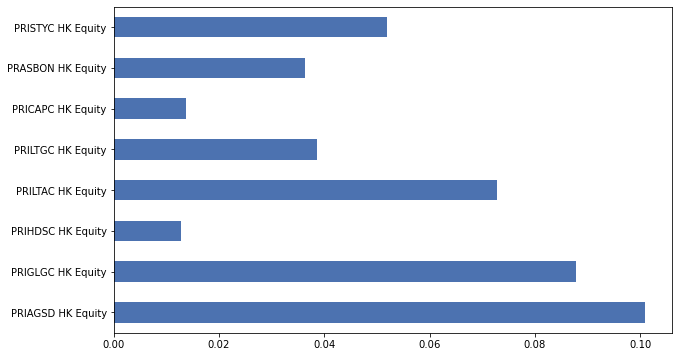

In [228]:
#calculate the asset returns in our portfolio.
ret_data = tsixteen.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff16 = (sum(port_ret) - ret)*100
print(diff16)
print("Percentage change compared to train set (+- %):")
perch16 = diff16/ret
print(perch16)
compare16=((sum(port_ret)*100)-6.66)
print("Compare to benchmark (+- %):")
print(compare16)

tmu16.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 16th five-year Backtesting  (for Function 1a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.31214), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.23017), ('PRISTYC HK Equity', 0.4577)])
Performance of function 1a portfolio in train period:


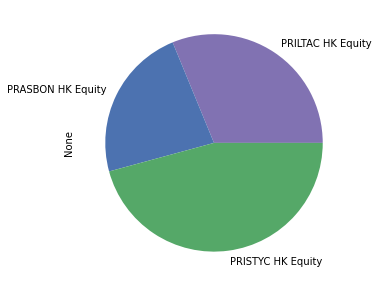

In [229]:
ef = EfficientFrontier(mu16_1, S16_1)

weight1a = ef.max_sharpe() #raw weights
cleanweight1a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

### Comparison - Performance of Portfolio during the Train period.

Expected annual return: 4.4%
Annual volatility: 2.8%
Sharpe Ratio: 0.87


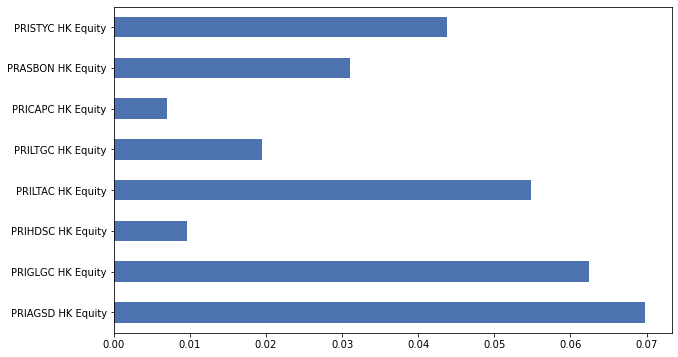

In [230]:
ret,vol,sharpe = ef.portfolio_performance(verbose=True)

mu16_1.plot.barh(figsize=(10,6))    #return of each funds from 2010 to 2014.

Portfolio return in test year(%):
3.934533714631453
Portfolio return compared to train set (+- %):
-0.4959142344200501
Percentage change compared to train set (+- %):
-30.269394036907897
Compare to benchmark (+- %):
-2.725466285368547


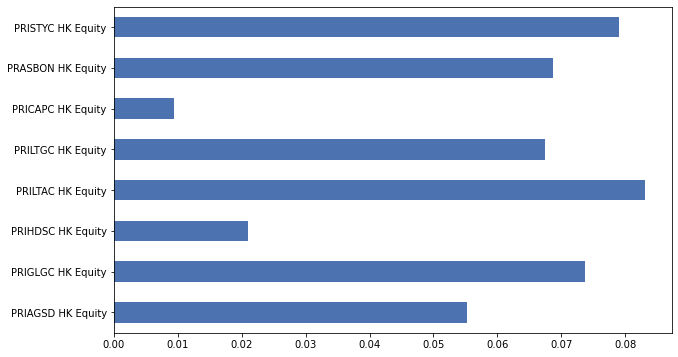

In [231]:
#calculate the asset returns in our portfolio.
ret_data = tsixteen1.pct_change()[1:]

#calculate the weighted returns of our assets.
weighted_returns = (cleanweight1a * ret_data)

#portfolio returns are simply the sum of the weighted returns of the assets. So lets add the rows.
port_ret = weighted_returns.sum(axis=1)
print("Portfolio return in test year(%):")
print(sum(port_ret)*100)
print("Portfolio return compared to train set (+- %):")
diff16_1 = (sum(port_ret) - ret)*100
print(diff16_1)
print("Percentage change compared to train set (+- %):")
perch16_1 = diff16_1/ret
print(perch16)
compare16_1=((sum(port_ret)*100)-6.66)
print("Compare to benchmark (+- %):")
print(compare16_1)

tmu16_1.plot.barh(figsize=(10,6))  #return of each fund from 2014 to 2015. (test period)

## Summary of Backtesting of Function 1a

In [233]:
perch_all = [perch1,perch2,perch3,perch4,perch5,perch6,perch7,perch8,perch9,perch10,perch11,perch12,perch13,perch14,perch15,perch16,perch1_1,perch2_1,perch3_1,perch4_1,perch5_1,perch6_1,perch7_1,perch8_1,perch9_1,perch10_1,perch11_1,perch14_1,perch15_1,perch16_1]
compare_all = [compare1,compare2,compare3,compare4,compare5,compare6,compare7,compare8,compare9,compare10,compare11,compare12,compare13,compare14,compare15,compare16,compare1_1,compare2_1,compare3_1,compare4_1,compare5_1,compare6_1,compare7_1,compare8_1,compare9_1,compare10_1,compare11_1,compare14_1,compare15_1,compare16_1]
mean_perch = sum(perch_all) / len(perch_all)
mean_compare = sum(compare_all) / len(compare_all)

print( "Function 1a Average error (%): " + str(mean_perch))
print( "Function 1a Average return compare to Benchmark(%): " + str(mean_compare))
#print( "Function 1a Accuracy (%): " + str(100-mean_perch))

Function 1a Average error (%): -58.052383416551606
Function 1a Average return compare to Benchmark(%): -0.21282046925194448


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
## Function 2a - Portfolio Optimization with given Risk Tolerance
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

Text(0.5, 1.0, 'Fund Portfolio')

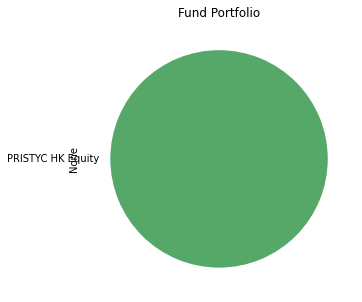

In [98]:
ef = EfficientFrontier(mu1, S1)

ef.efficient_risk(target_volatility=0.1) #input desired volatility - default as ten percent
weights = ef.clean_weights()
weights

pd.Series(weights).plot.pie(figsize=(5,5))
plt.title("Fund Portfolio")

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 1st five-year Backtesting  (for Function 2a)

### Run the function - what's the weighting for this period?

OrderedDict([('PRIAGSD HK Equity', 0.0), ('PRIGLGC HK Equity', 0.0), ('PRIHDSC HK Equity', 0.0), ('PRILTAC HK Equity', 0.39732), ('PRILTGC HK Equity', 0.0), ('PRICAPC HK Equity', 0.0), ('PRASBON HK Equity', 0.0), ('PRISTYC HK Equity', 0.60268)])
Performance of function 1a portfolio in train period:


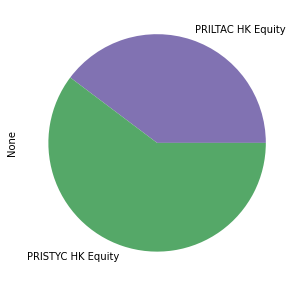

In [118]:
ef = EfficientFrontier(mu15, S15)

weight2a = ef.max_sharpe() #raw weights
cleanweight2a = ef.clean_weights() #cleaned weights
print(cleanweight1a)
print("Performance of function 1a portfolio in train period:")
pd.Series(cleanweight1a).plot.pie(figsize=(5,5))

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Function 3 - Minimise risk for a given return

In [99]:
ef = EfficientFrontier(mu16, S16, weight_bounds=(None, None))
ef.efficient_return(target_return=0.05, market_neutral=True)
weights = ef.clean_weights()
weights

OrderedDict([('PRIAGSD HK Equity', -0.46506),
             ('PRIGLGC HK Equity', 0.53022),
             ('PRIHDSC HK Equity', 0.71831),
             ('PRILTAC HK Equity', 0.77989),
             ('PRILTGC HK Equity', -1.0),
             ('PRICAPC HK Equity', -1.0),
             ('PRASBON HK Equity', -0.29424),
             ('PRISTYC HK Equity', 0.73088)])

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## Plotting Efficient Frontier

In [120]:
from pypfopt import CLA, plotting

cla = CLA(mu1, S1)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 2.6%
Annual volatility: 3.9%
Sharpe Ratio: 0.16


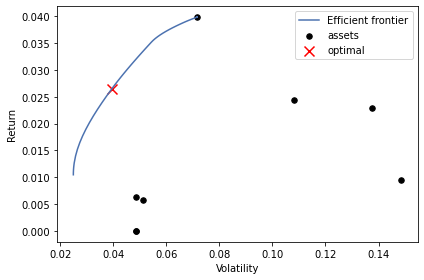

In [121]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)
![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

# This scheme in a nutshell:

##         Any portfolio with volatility higher than 11.1% is bad because you earn the same afterwards. The highest return you can get is 5.0%.

In [106]:
risktolerance, annualreturn = [], []
for rt2 in np.arange(0.02, 1, 0.001):
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(target_volatility=rt2)
    weights = ef.clean_weights()
    ret, volatility, Sharpe = ef.portfolio_performance(verbose=True)
    annualreturn.append(ret)
    risktolerance.append(rt2)


Expected annual return: 2.0%
Annual volatility: 2.0%
Sharpe Ratio: -0.02
Expected annual return: 2.0%
Annual volatility: 2.1%
Sharpe Ratio: 0.02
Expected annual return: 2.1%
Annual volatility: 2.2%
Sharpe Ratio: 0.05
Expected annual return: 2.2%
Annual volatility: 2.3%
Sharpe Ratio: 0.08
Expected annual return: 2.3%
Annual volatility: 2.4%
Sharpe Ratio: 0.11
Expected annual return: 2.3%
Annual volatility: 2.5%
Sharpe Ratio: 0.13
Expected annual return: 2.4%
Annual volatility: 2.6%
Sharpe Ratio: 0.15
Expected annual return: 2.5%
Annual volatility: 2.7%
Sharpe Ratio: 0.18
Expected annual return: 2.5%
Annual volatility: 2.8%
Sharpe Ratio: 0.19
Expected annual return: 2.6%
Annual volatility: 2.9%
Sharpe Ratio: 0.21
Expected annual return: 2.7%
Annual volatility: 3.0%
Sharpe Ratio: 0.23
Expected annual return: 2.8%
Annual volatility: 3.1%
Sharpe Ratio: 0.24
Expected annual return: 2.8%
Annual volatility: 3.2%
Sharpe Ratio: 0.26
Expected annual return: 2.9%
Annual volatility: 3.3%
Sharpe Rat

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.26
Expected annual return: 5.0%
Annual volatility: 11.

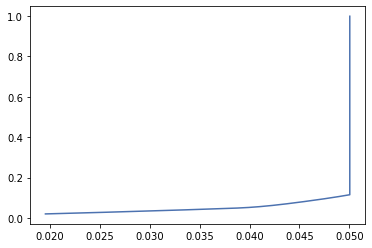

In [76]:
plt.plot(annualreturn, risktolerance)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)